In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../scripts/results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","


df = pd.read_pickle("./pset3_06mm.pkl")  # cid, pSet, rr, 1 or 9

In [2]:

#outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
#column_names = outputvalsname + paramsets.columns.tolist()
def getnewval_cell(df):
    #outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
    #column_names = outputvalsname + paramsets.columns.tolist()
    for konzz in ['theta','coa','cod','cca','ccd','css','co2']:
        df[konzz] = df['partialQ_'+konzz]/df['partial_volume']
    for konzz in ['cs','cl']:
        df[konzz] = df['partialQ_'+konzz+'soil']/df['partialQ_theta']#/df['partial_volume']
    df['vols'] = df['partial_volume']
    df['wat'] = df['partialQ_theta']
    try:
        df['css']=df['css2']
    except:
        pass
    df['cxd']=df['cod']+df['ccd']
    df['cxa']=df['coa']+df['cca']
    df['co'] = df['cod']+df['coa']
    df['cc'] = df['ccd']+df['cca']
    df['cx']=df['co']+df['cc']
    df['cxd_cx']=df['cxd']/df['cx']
    df['cxa_cx']=df['cxa']/df['cx']
     

    try:
        df['theta']=df['wat']/df['vols']
    except:
        try:
            df['theta']=df['wat']/df['vol']
        except:
            pass
        pass
    #df  = pd.merge(df, paramsets[['pSet', 'theta_th']], on="pSet")
    #df['csBis'] = df['cs']*df['theta']/df['theta_th']
    #df['clBis'] = df['cl']*df['theta']/df['theta_th']
    # per unit of soil volume
    df['cs_'] = df['cs']*df['theta']
    df['cl_'] = df['cl']*df['theta']
    df['soc']=df['cs_']+df['css']+df['cl_']+df['cx'] # df['socinit']
    #df.loc[df['scenario'] == "earlyDry",'scenario']="earlyDry"  # Select subset where 'pSet' equals the current value
    
    solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
    solidMolarMass = 60.08e-3 # [kg/mol] 
    thetaS= 0.43
    mgC_per_molC=12.011*1000
    
    massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3
    print('massBulkDensity',massBulkDensity)
    #df['pSet']=df['scenario']+'_'+df['pSet']

    bulkD = massBulkDensity# g/cm3 soil * kg/g
    MmassC = 12.011 # gC/molC
    clay = 0.178*1000 # g/g to g/kg
    SOCexp = (clay*0.0288+13.674) / MmassC * bulkD/1000  # g C / kg soil => mol C/cm3 soil
    SOCreal = 0.0112/MmassC *bulkD# g/g => molC/cm3 soil, https://acsess.onlinelibrary.wiley.com/doi/10.2136/vzj2017.08.0152

    initSOC  ={'5':0.000261564277948825, '44':0.0002941431464338718, '61':0.0002833083349901329} # obtained from simulation
    
    df['socinit'] = [initSOC[pipi] for pipi in df['pSet']]
    df['socadded'] = SOCreal - df['socinit']
    df['socadapted'] = df['socadded'] + df['soc']
    # mol/cm3 scv to mg C pool/g C mineral
    if False:
        for nnn in ['cs_','cl_','co','cc','coa','cod','cca','ccd','css']:
            # mol C/cm3 *  
            df[nnn+'_mass'] = df[nnn]*mgC_per_molC / massBulkDensity
    return df
dfmean = getnewval_cell(df)
dfmean['pSetscenario']=np.char.add(np.array(dfmean['pSet'],dtype=str),np.array(dfmean['scenario'],dtype=str))

massBulkDensity 1.5105000000000002


In [3]:
dfmeanTot = dfmean.groupby(["time", "scenario", "pSet"])[  ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']]].agg('sum').reset_index()

In [4]:
dfmeanTot['totC'] = dfmeanTot[  ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']] ].sum(axis=1)

In [5]:
dfmeanTotrel = dfmeanTot.copy()
dfmeanTotrel[['totC'] + [
    'partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']] 
            ] =dfmeanTotrel[['totC'] + ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']] ].div(dfmeanTot['totC'], axis=0)

In [6]:
dfmeanTotrel['pSetscenario'] = dfmeanTotrel['pSet']+dfmeanTotrel['scenario']
dfmeanTotrel['microbes'] = dfmeanTotrel[ ['partialQ_'+konzz for konzz in ['coa','cod','cca','ccd']]].sum(axis=1)
dfmeanTotrel['solutes'] = dfmeanTotrel[ ['partialQ_'+konzz for konzz in ['cssoil','clsoil','css']]].sum(axis=1)
dfmeanTotrel['$CO_2$'] =  dfmeanTotrel['partialQ_co2']

In [54]:
dfmeanTot2 = dfmeanTot.copy()
dfmeanTot2['pSetscenario'] = dfmeanTot2['pSet'].astype(str)+dfmeanTot2['scenario']
dfmeanTot2['microbes'] = dfmeanTot2[ ['partialQ_'+konzz for konzz in ['coa','cod','cca','ccd']]].sum(axis=1)
dfmeanTot2['activated microbes'] = dfmeanTot2[ ['partialQ_'+konzz for konzz in ['coa','cca','ccd']]].sum(axis=1)
dfmeanTot2['solutes'] = dfmeanTot2[ ['partialQ_'+konzz for konzz in ['cssoil','clsoil','css']]].sum(axis=1)
dfmeanTot2['$CO_2$'] =  dfmeanTot2['partialQ_co2']

############

In [9]:
dfbulksoil = pd.read_pickle('./soil3dData.pkl')
dfbulksoil = dfbulksoil[dfbulksoil['gotR']].copy().reset_index()

AllCells = np.array(list(set(dfbulksoil['cellindx'].values))) # for macroscale

dfbulksoil[[ 'cs', 'cl']
           ] =dfbulksoil[[ 'cs', 'cl'] ].mul(dfbulksoil['theta'], axis=0)
dfbulksoil[[ 'cs', 'css','cl','cc','co','co2','cca','coa' ]
           ] =dfbulksoil[[ 'cs', 'css','cl','cc','co' ,'co2','cca','coa'] ].mul(dfbulksoil['volscv'], axis=0)
dfbulksoil['totC']=dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ] ].sum(axis=1)
dfbulksoil = dfbulksoil.groupby(["time", "scenario", "pSet"])[ [ 'cs', 'css','cl','cc','co','cca','coa','co2','totC' ] ].agg('sum').reset_index()

dfbulksoil['activated microbes'] = dfbulksoil[ ['cca','coa']].sum(axis=1)
dfbulksoil['microbes'] = dfbulksoil[ ['co','cc']].sum(axis=1)
dfbulksoil['solutes'] = dfbulksoil[ ['cs', 'css','cl']].sum(axis=1)
dfbulksoil['$CO_2$'] =  dfbulksoil['co2']

dfbulksoil['pSetscenario'] =np.array( dfbulksoil['pSet'], dtype=str)+dfbulksoil['scenario']
dfbulksoil['pSet']=dfbulksoil['pSet'].astype(str)

In [10]:
dfmacroksoil = pd.read_pickle('./soil3dData.pkl') # AllCells
dfmacroksoil = dfmacroksoil[dfmacroksoil['cellindx'].isin(AllCells)]
dfmacroksoil[[ 'cs', 'cl']
           ] =dfmacroksoil[[ 'cs', 'cl'] ].mul(dfmacroksoil['theta'], axis=0)
dfmacroksoil[[ 'cs', 'css','cl','cc','co','co2','cca','coa' ]
           ] =dfmacroksoil[[ 'cs', 'css','cl','cc','co' ,'co2','cca','coa'] ].mul(dfmacroksoil['volscv'], axis=0)
dfmacroksoil['totC']=dfmacroksoil[[ 'cs', 'css','cl','cc','co','co2' ] ].sum(axis=1)
dfmacroksoil = dfmacroksoil.groupby(["time", "scenario", "pSet"])[ [ 'cs', 'css','cl','cc','co','cca','coa','co2','totC' ] ].agg('sum').reset_index()

dfmacroksoil['activated microbes'] = dfmacroksoil[ ['cca','coa']].sum(axis=1)
dfmacroksoil['microbes'] = dfmacroksoil[ ['co','cc']].sum(axis=1)
dfmacroksoil['solutes'] = dfmacroksoil[ ['cs', 'css','cl']].sum(axis=1)
dfmacroksoil['$CO_2$'] =  dfmacroksoil['co2']

dfmacroksoil['pSetscenario'] =np.array( dfmacroksoil['pSet'], dtype=str)+dfmacroksoil['scenario']
dfmacroksoil['pSet']=dfmacroksoil['pSet'].astype(str)

In [11]:
dfmacroksoil[ [ 'csrel', 'cssrel','clrel','ccrel','corel','co2rel','totCrel' ] 
            ] =dfmacroksoil[ [ 'cs', 'css','cl','cc','co','co2','totC' ]  ].div(dfmacroksoil['totC'], axis=0)
dfmacroksoil['microbesRel'] = dfmacroksoil[ ['corel','ccrel']].sum(axis=1)
dfmacroksoil['solutesRel'] = dfmacroksoil[ ['csrel', 'cssrel','clrel']].sum(axis=1)
dfmacroksoil['$CO_2$Rel'] =  dfmacroksoil['co2rel']

In [17]:
import string
import matplotlib.ticker as mtick
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
l_styles = {5:'-',44:'--',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#8da0cb',  # Blue
    'earlyDry':  '#66c2a5' ,  # Green
    'lateDry': '#fc8d62'  # red
}
color_legend_elements = [
    #Line2D([0], [0], color=c_styles['baseline'], lw=5, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=5, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=5, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=6, label="highCO2"),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=6, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=6, label="highMB"),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=6, label="lowMUptake")
]
def diffCUsage(dataframe_,  
                    dependent_variable,
               ylab=None, xlab=None,
               doTitle=True,
                    xlim=None,ylim=None,
               indexsubplotLegend1=-1,
               indexsubplotLegend2=-1,
                   dosave=False, doshow=True, savedir='./',
                    saveName='myimage',commonLim=False,
                    ax=None, fig=None,
                   indexsubplot=0, 
                   bbox_to_anchor1=(0.5, 0.7),bbox_to_anchor2=(0.5, 0.3)):


    
    dataframe = dataframe_.copy()

    # Loop for each subplot
    #scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    pSetscenarios = dataframe['pSetscenario'].unique()
    #ncols = len(scenarios)
    nrows = len(pSets)
        
    # Create the plot
    if ax is None:
        plt.figure(figsize=(8, 6))  # Adjust figure size if needed
        fillout = plt.gca()
    else:
        fillout = ax
        
    for pset_ in pSets:
        for scenario_ in np.array( ['earlyDry', 'lateDry']):
            psetScenario = str(pset_)+str(scenario_)
            df_baseline =dataframe[dataframe['pSetscenario']==(str(pset_)+'baseline')].copy().reset_index()
            df__ =dataframe[dataframe['pSetscenario']==psetScenario].copy().reset_index()

            #for depVar in ['microbes','solutes','$CO_2$']:

            results_rel = (df__[dependent_variable].values - df_baseline[dependent_variable].values)/df_baseline[dependent_variable].values
            allcc = ["#fc8d62","#66c2a5","#8da0cb"]
            #widths= [1,1,1,1,1,1,1,1]



            fillout.plot(df__['time'],results_rel,
                     linewidth=3,
                         c=c_styles[df__['scenario'].unique()[0]],
                         linestyle=l_styles[int(df__['pSet'].unique()[0])]
                    )

    fillout.set_ylabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
    
    fillout.tick_params(axis='both', which='major', labelsize=18)

    if doTitle:
        fillout.set_title(str(int(time*10)/10), fontsize=20)

    fillout.axvline(x=18, color='k', linestyle='--')
    fillout.axvline(x=25, color='k', linestyle='--')
    fillout.axvline(x=11, color='k', linestyle='--')
            
    if indexsubplot == indexsubplotLegend1:
        color_legend = fillout.legend(handles=color_legend_elements, ncols=3,
                   fontsize=20,title_fontsize='25', title='scenario', 
                   loc='upper left' #,  ncol=1, bbox_to_anchor=bbox_to_anchor1
                                     )#(0.5, 0.7))
        fillout.add_artist(color_legend)
    if indexsubplot == indexsubplotLegend2:
        linestyle_legend = fillout.legend(handles=linestyle_legend_elements,  ncols=3,
                   fontsize=20,title_fontsize='25', title='parameter set', 
                   loc='upper left'#,  ncol=1, bbox_to_anchor=bbox_to_anchor2
                                         )#(0.5, 0.3))
        fillout.add_artist(linestyle_legend)

    if indexsubplot < 3:
        fillout.set_xticklabels([])
    else:
        fillout.set_xlabel(ylab, fontsize=20)
        
    if ylim is not None:
        fillout.set_ylim(ymin=ylim[0],ymax=ylim[1])
        
    if ax is None: 
        plt.tight_layout() 
    else:
        # Get the corresponding letter label
        label = '('+string.ascii_lowercase[indexsubplot]+')'
        fillout.annotate(
                label,
                xy=(0, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    if ax is None: 
        plt.close()

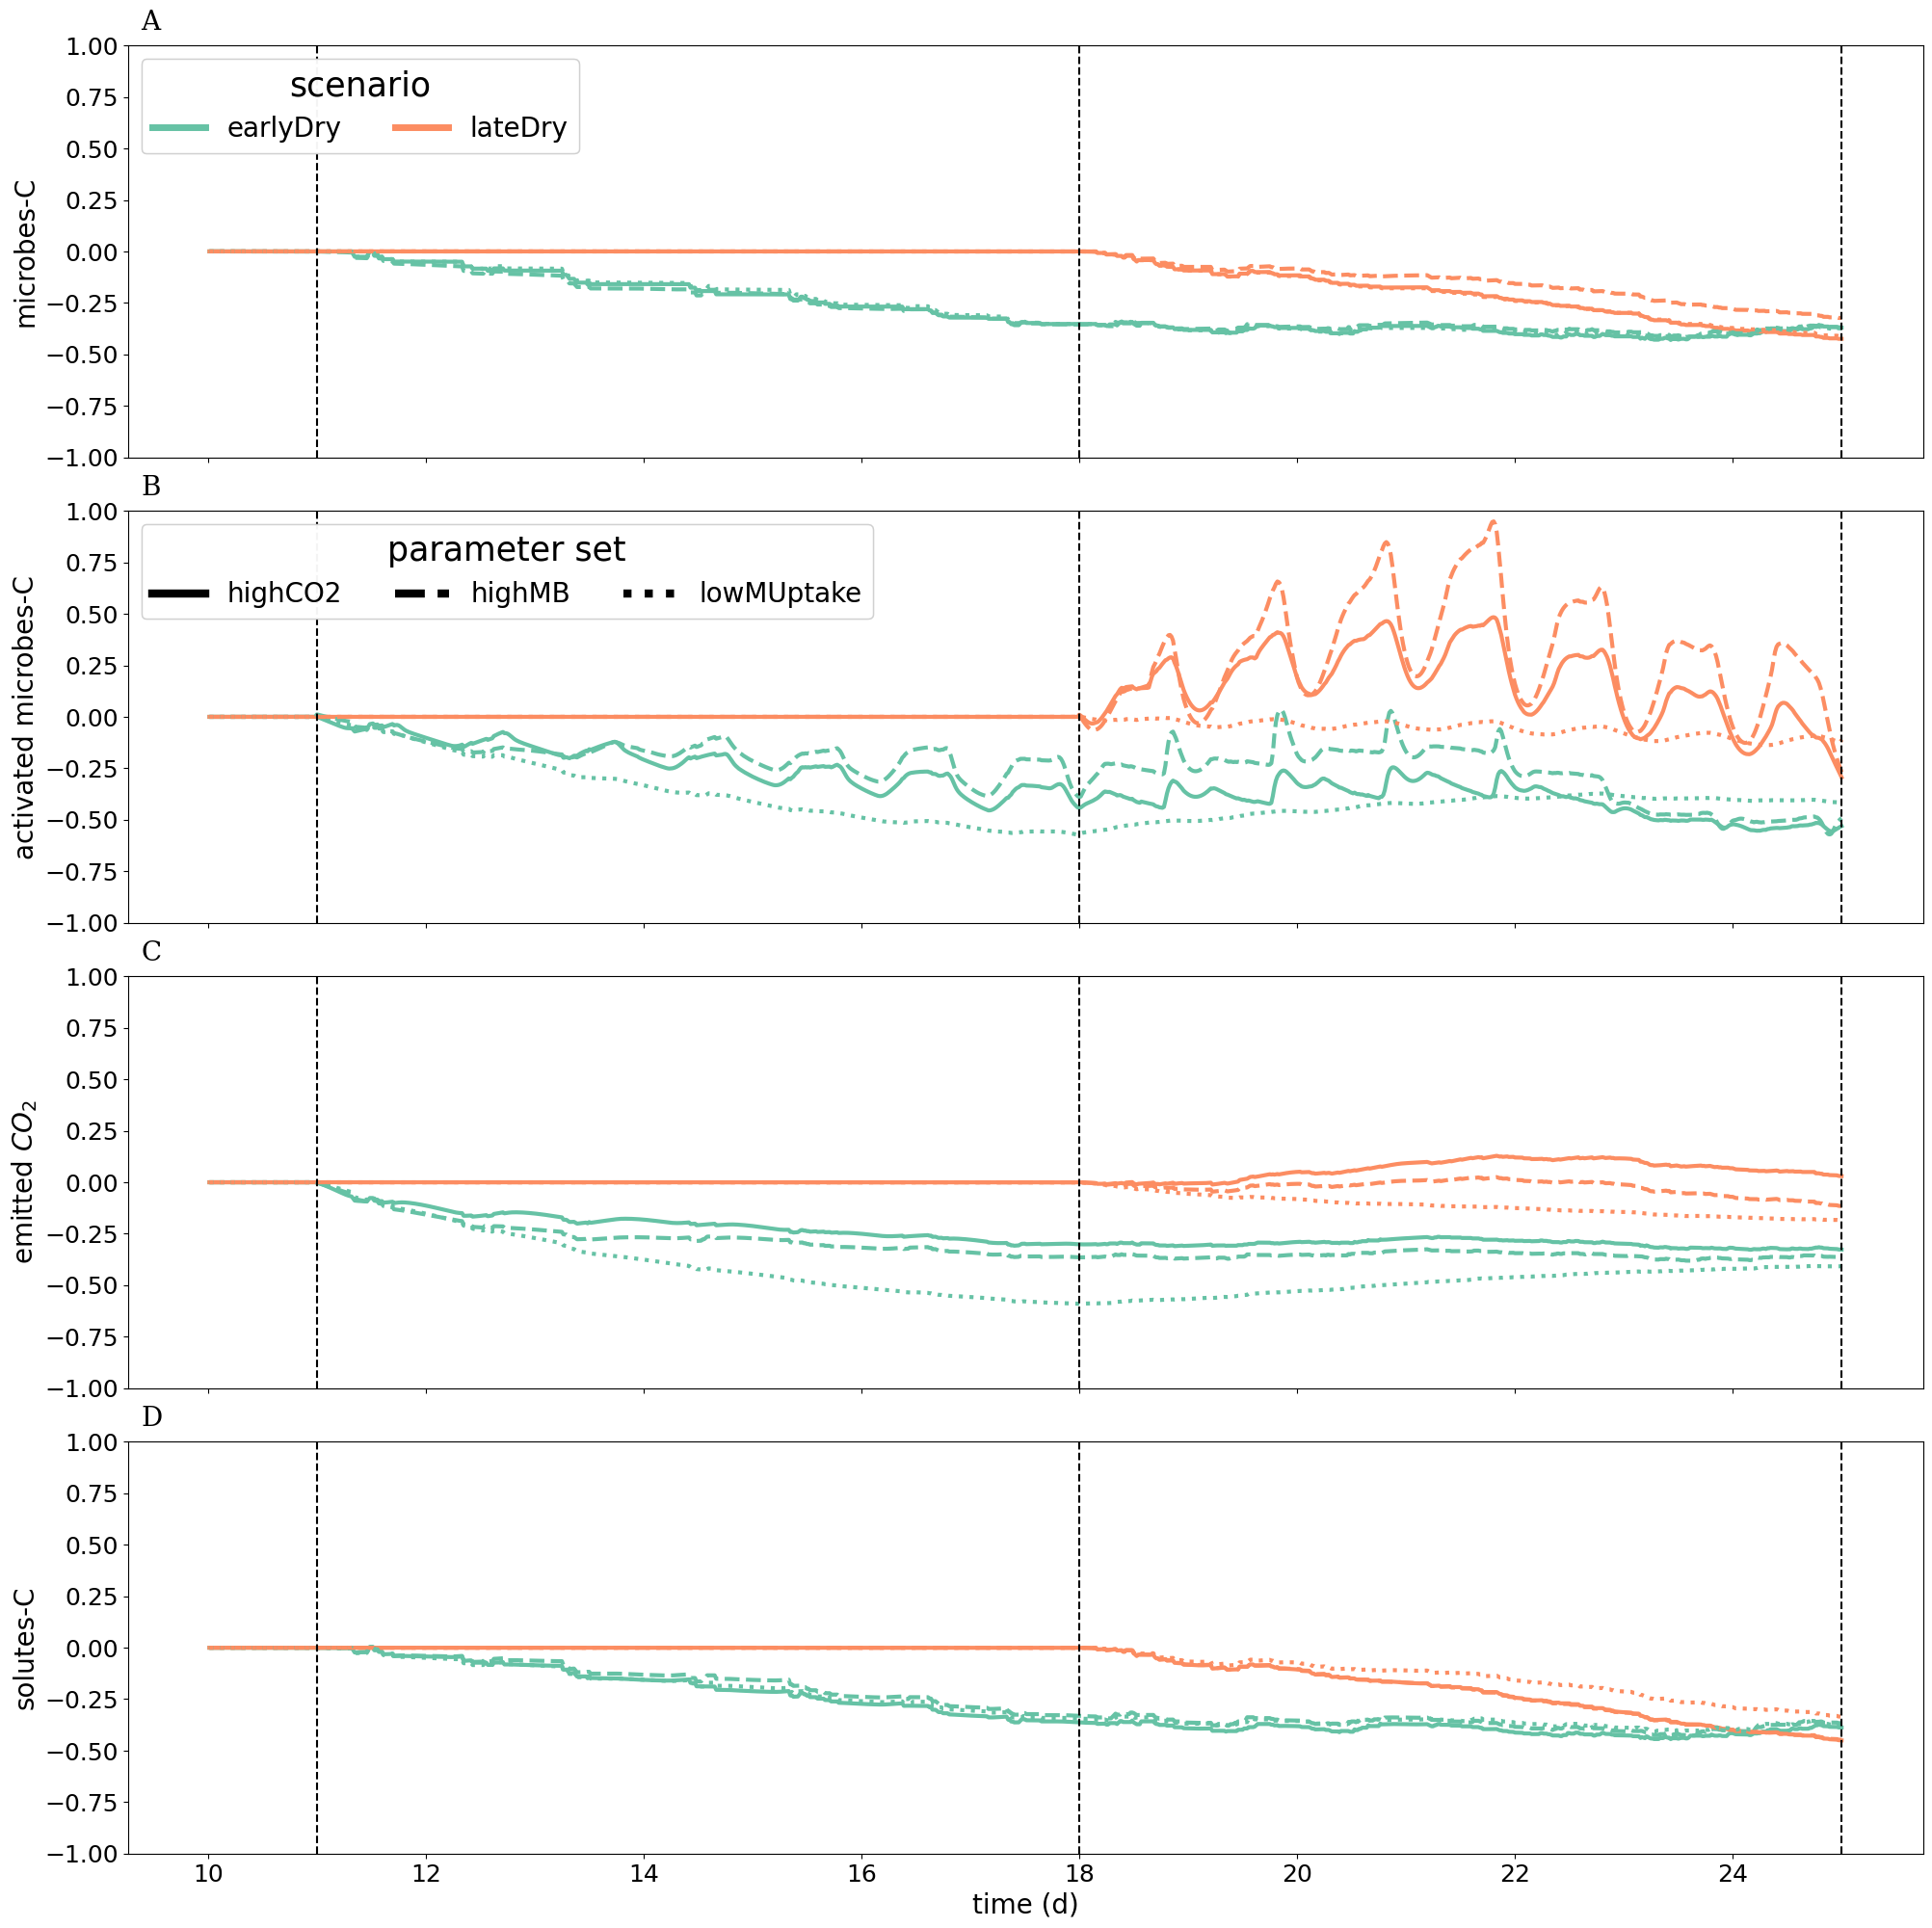

In [123]:
units ={'microbes': '$\mu mol~C/cm^3$ scv','solutes': '$mmol~C/cm^3$ scv',
           '$CO_2$':  '$\mu mol~C/cm^3$ scv'} 

unitChange={'css': 1e3,'co2': 1e3,
           'coa': 1e6,'cod': 1e6,'co':1e6 ,
           'cca':1e3,'ccd': 1e3,'cc':1e3,
           'cs':1e6,'cl':1e6}  
xlabels = {'microbes': 'microbes-C','solutes': 'solutes-C',
           '$CO_2$':'emitted $CO_2$','activated microbes':'activated microbes-C'} 
xxx = ['microbes','activated microbes','$CO_2$', 'solutes']


fig, axs = plt.subplots(4, 1, figsize=(20,20))
for indexsubplot in range(len(xxx)):
    
    diffCUsage(dfbulksoil, xxx[indexsubplot], 
                ylab='time (d)', xlim=None,doTitle=False,ylim=[-1,1],
                    indexsubplotLegend1=0,indexsubplotLegend2=1,
                xlab=xlabels[xxx[indexsubplot]],#+" (-)",
                    doshow = False, ax=axs.flat[indexsubplot], 
                    fig=fig,indexsubplot=indexsubplot, 
                  # labelsnoYY = np.array([0,1,2,3,4,5]),
                    bbox_to_anchor1=(0.5, 0.8),bbox_to_anchor2=(0.5, 0.4))
    
    
plt.tight_layout()  

plt.savefig('CUsage_soil.png')
plt.show() # dfmacroksoil

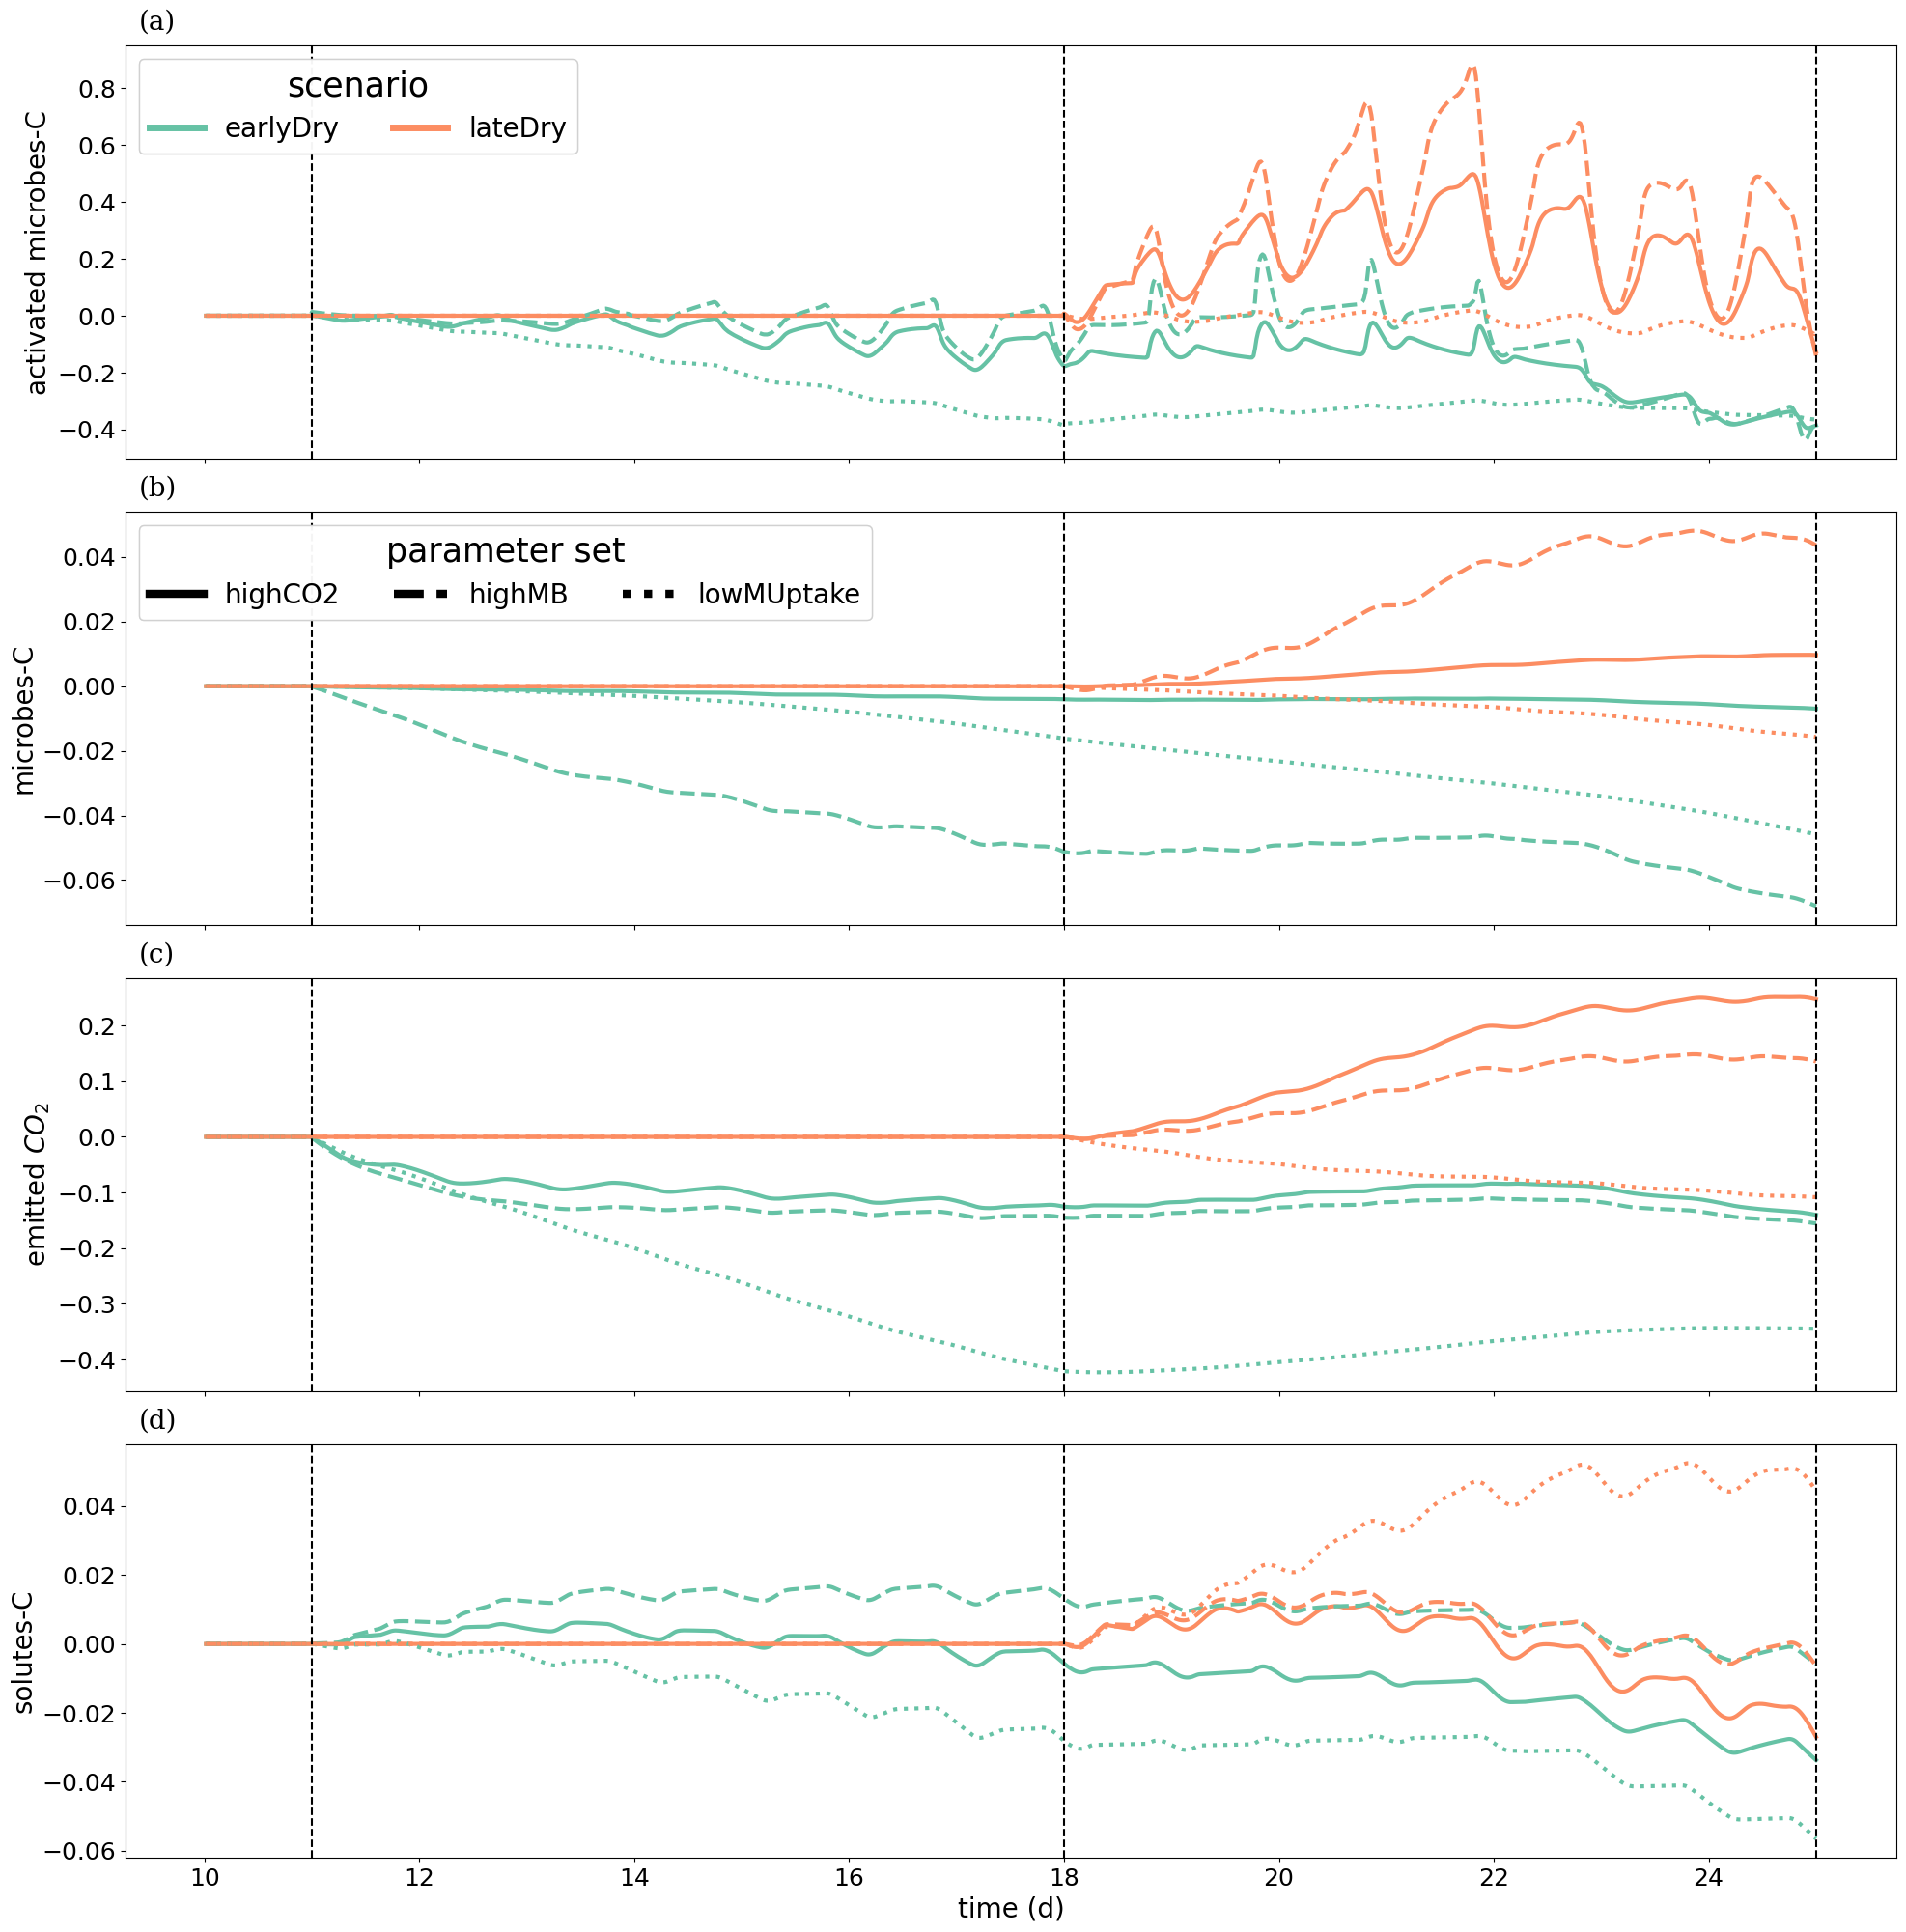

In [18]:
units ={'microbes': '$\mu mol~C/cm^3$ scv','solutes': '$mmol~C/cm^3$ scv',
           '$CO_2$':  '$\mu mol~C/cm^3$ scv'} 

unitChange={'css': 1e3,'co2': 1e3,
           'coa': 1e6,'cod': 1e6,'co':1e6 ,
           'cca':1e3,'ccd': 1e3,'cc':1e3,
           'cs':1e6,'cl':1e6}  
xlabels = {'microbes': 'microbes-C','solutes': 'solutes-C',
           '$CO_2$':'emitted $CO_2$','activated microbes':'activated microbes-C'} 
xxx = ['activated microbes','microbes','$CO_2$', 'solutes']

fig, axs = plt.subplots(4, 1, figsize=(20,20))
for indexsubplot in range(len(xxx)):
    
    diffCUsage(dfmacroksoil, xxx[indexsubplot], 
                ylab='time (d)', xlim=None,doTitle=False,ylim=None,#[-1,1],
                    indexsubplotLegend1=0,indexsubplotLegend2=1,
                xlab=xlabels[xxx[indexsubplot]],#+" (-)",
                    doshow = False, ax=axs.flat[indexsubplot], 
                    fig=fig,indexsubplot=indexsubplot, 
                  # labelsnoYY = np.array([0,1,2,3,4,5]),
                    bbox_to_anchor1=(0.5, 0.8),bbox_to_anchor2=(0.5, 0.4))
    
    
plt.tight_layout()  

plt.savefig('CUsage_macrosoil.png')
plt.show() # 

In [113]:
dfall = dfmacroksoil.copy() #pd.read_pickle('./soil3dData.pkl')
#dfbulksoil = dfbulksoil[dfbulksoil['gotR']].copy().reset_index()
dfall['scale']="macroscale"


dfall1825 = dfall.loc[(abs(dfall['time']-18.)==min(abs(dfall['time']-18.))
                                    )|(
    dfall['time']==max(dfall['time'])
),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes','$CO_2$Rel','microbesRel', 'solutesRel', 'time']
                     ].copy().reset_index(drop=True)
dfall1825['scale'] = 'macroscale'
df_bigabs = dfall1825.copy() #pd.concat([df0061825,dfall1825], ignore_index=True) 

df_bigabs[['$CO_2$','microbes', 'solutes']]*=1000. #,'$CO_2$Rel','microbesRel', 'solutesRel'
df_bigabs[['$CO_2$Rel','microbesRel', 'solutesRel']]*=100. #,'$CO_2$Rel','microbesRel', 'solutesRel'
df_bigabs[['$CO_2$','microbes', 'solutes']]=df_bigabs[
    ['$CO_2$','microbes', 'solutes']].round(1)
df_bigabs[['$CO_2$Rel','microbesRel', 'solutesRel']]=df_bigabs[
    ['$CO_2$Rel','microbesRel', 'solutesRel']].round(0)
df_wide_absall = df_bigabs.pivot_table(index=['pSet', 'scenario'], columns=['scale','time'], values=['$CO_2$', 'microbes', 'solutes'])
df_wide_absall = df_wide_absall.swaplevel(0, 1, axis=1).sort_index(axis=1)
df_wide_absall.style.to_latex('absDistribMacro_1825.tex', sparse_index=False)

df_wide_absallRel = df_bigabs.pivot_table(index=['pSet', 'scenario'], columns=['scale','time'], values=['$CO_2$Rel','microbesRel', 'solutesRel'])
df_wide_absallRel = df_wide_absallRel.swaplevel(0, 1, axis=1).sort_index(axis=1)
df_wide_absallRel.style.to_latex('absDistribMacro_1825Rel.tex', sparse_index=False)


In [106]:
df_wide_absall

scale         macroscale                                  
                  $CO_2$       microbes      solutes      
time                18.0  25.0     18.0 25.0    18.0  25.0
pSet scenario                                             
44   baseline       16.3  24.8      6.6  7.7    55.6  53.1
     earlyDry       13.9  21.0      6.3  7.1    56.3  52.8
     lateDry        16.3  28.2      6.6  8.0    55.6  52.7
5    baseline       11.5  19.3      4.8  4.9    54.2  53.3
     earlyDry       10.1  16.6      4.8  4.8    53.9  51.5
     lateDry        11.5  24.1      4.8  4.9    54.2  51.9
61   baseline        0.2   0.9      4.8  5.4    70.8  76.6
     earlyDry        0.1   0.6      4.8  5.1    68.8  72.2
     lateDry         0.2   0.8      4.8  5.3    70.8  80.0

In [114]:
df_wide_absallRel

scale         macroscale                                        
               $CO_2$Rel       microbesRel      solutesRel      
time                18.0  25.0        18.0 25.0       18.0  25.0
pSet scenario                                                   
44   baseline       21.0  29.0         8.0  9.0       71.0  62.0
     earlyDry       18.0  26.0         8.0  9.0       74.0  65.0
     lateDry        21.0  32.0         8.0  9.0       71.0  59.0
5    baseline       16.0  25.0         7.0  6.0       77.0  69.0
     earlyDry       15.0  23.0         7.0  7.0       78.0  71.0
     lateDry        16.0  30.0         7.0  6.0       77.0  64.0
61   baseline        0.0   1.0         6.0  6.0       93.0  92.0
     earlyDry        0.0   1.0         6.0  7.0       93.0  93.0
     lateDry         0.0   1.0         6.0  6.0       93.0  93.0

In [112]:
print(20.7+8.4+70.8,29.0+8.9+62.0)

99.9 99.9


In [ ]:
dfallrel = dfmacroksoil.copy()
dfallrel['microbes'] = dfall[ ['corel','ccrel']].sum(axis=1)
dfallrel['solutes'] = dfall[ ['csrel', 'cssrel','clrel']].sum(axis=1)
dfallrel['$CO_2$'] =  dfall['co2rel']

In [ ]:
def cumsum_and_plotAllcontentvstime(dataframe_,ylab=None, xlab=None,vividlim=-1,
                   dosave=False, doshow=True, savedir='./', saveName='myimage',
                                    legendLabel={},depVars=[],
                      sizerows=8,sizecols=6,colidLegend=0, rowidLegend=0):
    for extraText in [savedir]:
        if not os.path.exists(extraText):
            os.makedirs(extraText)

    
    dataframe = dataframe_.copy()

    # Loop for each subplot
    scenarios =np.array( ['baseline', 'earlyDry', 'lateDry'])
    pSets = np.array([5,44,61])
    
    pSetscenarios = dataframe['pSetscenario'].unique()
    ncols = len(scenarios)
    nrows = len(pSets)
        
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols)) 
    for psetScenario in pSetscenarios:
        
        df__ =dataframe[dataframe['pSetscenario']==psetScenario].copy().reset_index()

        rowid = np.where(int(df__['pSet'].unique()[0])==pSets)[0] 
        if ncols > 1:
            colid = np.where(df__['scenario'].unique()[0]==scenarios)[0] 
            ax_ = ax[rowid, colid][0]
        else:
            colid = 0
            ax_ = ax[rowid]
        
        
        allcc = ["#fc8d62","#66c2a5","#8da0cb"]
        widths= [1,1,1,1,1,1,1,1]
        addedVals = np.zeros(df__['time'].shape)
        for vivid, vivi in enumerate(depVars):
            if vivi in legendLabel.keys():
                labvivi = legendLabel[vivi]
            else:
                labvivi = vivi
                

            ax_.plot(df__['time'],df__[vivi]+addedVals,
                     linewidth=widths[vivid],
                             label=f'{labvivi}',
                             c=allcc[vivid],
                             #linestyle=l_styles[int(df__['pSet'].unique()[0])]
                    )
            if vivid > vividlim:
                ax_.fill_between(df__['time'],addedVals,df__[vivi].values+addedVals ,color=allcc[vivid])
            addedVals += df__[vivi].values

        
        if (rowid==2) and (colid==1):
            ax_.set_xlabel(xlab, fontsize=20)#'maximum '+independent_variable+' (mol/cm3 water)')
        if (colid==0) and (rowid==1):
            ax_.set_ylabel(ylab, fontsize=20)
                
        
        pset2name = {'5':"highCO2",'44':"highMB",'61':"highSolutes"}
        if (colid==2):
            ax2 = ax_.twinx() # +"\n"+"parameter set "+df__['pSet'].unique()[0]
            if (rowid==1):
                ax2.set_ylabel(pset2name[df__['pSet'].unique()[0]]+"\nparameter set", fontsize=20)
            else:
                ax2.set_ylabel(pset2name[df__['pSet'].unique()[0]], fontsize=20)
            ax2.set_yticks([])
            
        ax_.tick_params(axis='both', which='major', labelsize=18)


        if df__['scenario'].unique()[0] == "lateDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=25, color='k', linestyle='--')
        if df__['scenario'].unique()[0] == "earlyDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')



        # Remove tick labels
        if rowid < 2:
            ax_.set_xticklabels([])
        if colid > 0:
            ax_.set_yticklabels([])
            
        ax_.grid(True)
        if (rowid==0):
            if (colid ==1) :
                ax_.set_title('weather scenario\n'+df__['scenario'].unique()[0], fontsize=20)
            else:#
                ax_.set_title(df__['scenario'].unique()[0], fontsize=20)
            
        
        if (colid == colidLegend) and (rowid==rowidLegend):
            handles, labels = ax_.get_legend_handles_labels()
            thick_handles = [plt.Line2D([], [], color=handle.get_color(), linewidth=6) for handle in handles]
            ax_.legend(thick_handles, labels, fontsize=20,title_fontsize='25', title='carbon pool')
            #ax_.legend(fontsize=20,title_fontsize='25', title='carbon pool')
            
        
        # Get the corresponding letter label
        label = string.ascii_uppercase[(rowid*ncols+colid)[0]]
        ax_.annotate(
                label,
                xy=(0, 1.12), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                fontsize='20', verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
        
    plt.tight_layout()  
    plt.grid(True)
    if dosave:
        plt.savefig(savedir+saveName+'.png', pad_inches=0.5)
    if doshow:
        plt.show()
    plt.close()

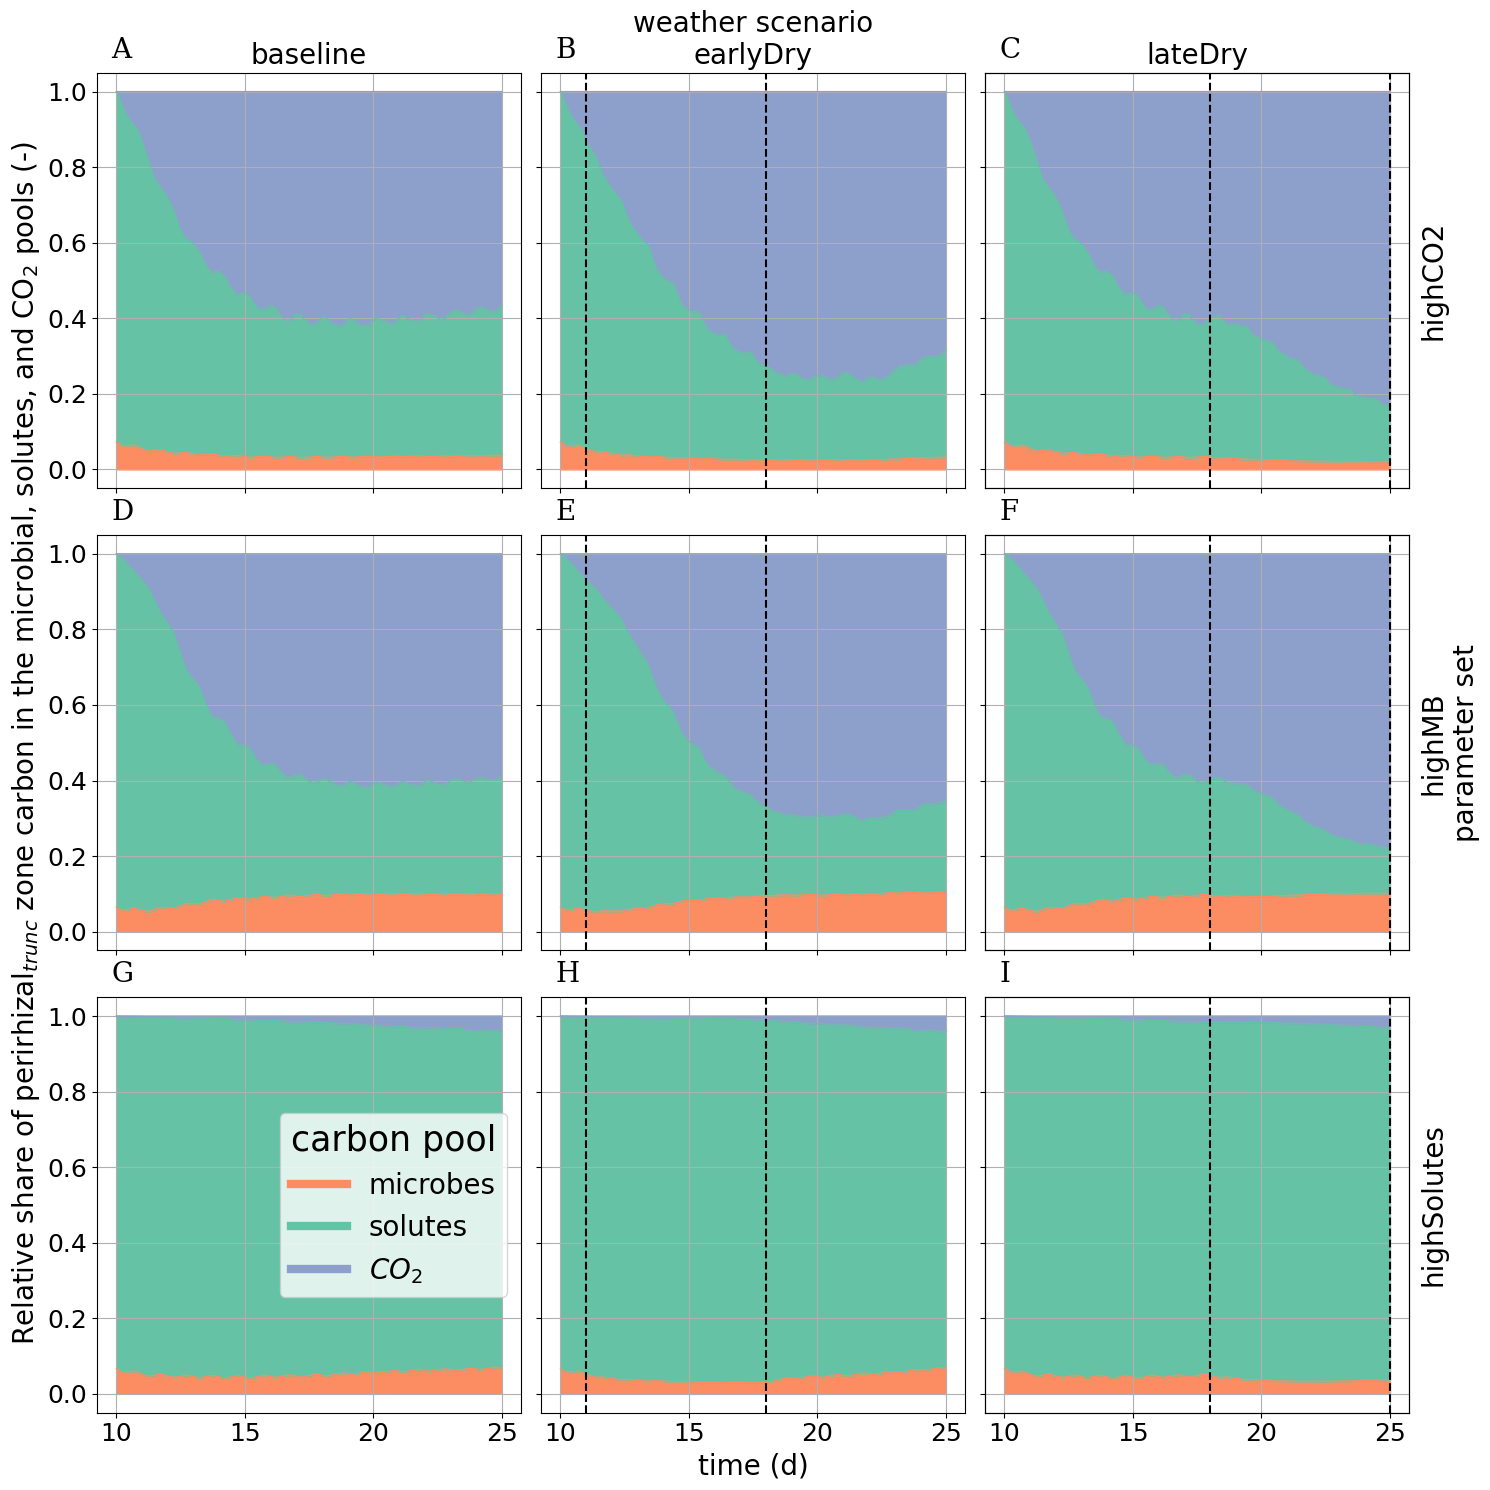

In [8]:
cumsum_and_plotAllcontentvstime(dataframe_=dfmeanTotrel,
                                ylab="Relative share of perirhizal$_{trunc}$ zone carbon in the microbial, solutes, and CO$_2$ pools (-)",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribRhizo',vividlim=-1,
                                    legendLabel={},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

In [9]:
dfmeanTotrel.columns

Index(['time', 'scenario', 'pSet', 'partialQ_cssoil', 'partialQ_clsoil',
       'partialQ_coa', 'partialQ_cod', 'partialQ_cca', 'partialQ_ccd',
       'partialQ_css', 'partialQ_co2', 'totC', 'pSetscenario', 'microbes',
       'solutes', '$CO_2$'],
      dtype='object')

In [9]:
dfmeanTotrel18 = dfmeanTotrel.loc[abs(dfmeanTotrel['time']-18.)==min(abs(dfmeanTotrel['time']-18.)),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes']].copy().reset_index()
dfmeanTotrel25 = dfmeanTotrel.loc[dfmeanTotrel['time']==max(dfmeanTotrel['time']),
                [ 'pSetscenario','$CO_2$','microbes', 'solutes']].copy().reset_index()
dfmeanTotrel1825 = dfmeanTotrel.loc[(abs(dfmeanTotrel['time']-18.)==min(abs(dfmeanTotrel['time']-18.))
                                    )|(
    dfmeanTotrel['time']==max(dfmeanTotrel['time'])
),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes', 'time']].copy().reset_index(drop=True)
dfmeanTotrel1825['time'] = pd.to_numeric(dfmeanTotrel1825['time'], downcast='integer')
dfmeanTotrel1825[['$CO_2$','microbes', 'solutes']] *= 100.

df = dfmeanTotrel1825.copy()
# Round the scaled values
df['CO2_scaled'] = df['$CO_2$'].round().astype(int)
df['microbes_scaled'] = df['microbes'].round().astype(int)
df['solutes_scaled'] = df['solutes'].round().astype(int)

df['sum'] = df['CO2_scaled'] + df['microbes_scaled'] + df['solutes_scaled']


# Ensure that the sum of the scaled values is exactly 100
def adjust_to_100(row):
    idData = np.where(row.index == 'CO2_scaled')[0][0]
    total = row['CO2_scaled'] + row['microbes_scaled'] + row['solutes_scaled']
    diff = 100 - total
    assert (abs(diff) == 1) or (abs(diff) == 0)
    #print(row[1])
    decidata = np.array([
        row['$CO_2$'] - row['CO2_scaled'] ,
        row['microbes'] - row['microbes_scaled'] ,
        row['solutes'] - row['solutes_scaled'] ]
    )
    # Adjust the largest value to compensate for the rounding difference
    if diff == -1: # need to remove 
        posrow = np.where(decidata==min(decidata))[0][0]
        
    if diff == 1: # need to remove 
        posrow = np.where(decidata==max(decidata))[0][0]
    
    if diff != 0:        
        #print('coucouA',diff,'index',idData + posrow,'sel',row.values[idData + posrow])
        row.values[idData + posrow] += diff
        #print('coucouB',diff,'sel',row.values[idData + posrow])
    return row

df_scaled = df.apply(adjust_to_100, axis=1)


df_scaled[['$CO_2$','microbes', 'solutes']] = df_scaled[['CO2_scaled','microbes_scaled','solutes_scaled']]
df_scaled_rel006 = df_scaled.drop(columns=['CO2_scaled','microbes_scaled','solutes_scaled', "sum", "sum_scaled"])

# Pivot the table
df_wide_rel006 = df_scaled_rel006.pivot_table(index=['pSet', 'scenario'], columns='time', values=['$CO_2$', 'microbes', 'solutes'])

df_wide_rel006.style.to_latex('relDistribPeriSoil_1825.tex', sparse_index=False)

KeyError: "['sum_scaled'] not found in axis"

In [10]:
dfbulksoil = pd.read_pickle('./soil3dData.pkl')
dfbulksoil = dfbulksoil[dfbulksoil['gotR']].copy().reset_index()
dfbulksoil[[ 'cs', 'cl']
           ] =dfbulksoil[[ 'cs', 'cl'] ].mul(dfbulksoil['theta'], axis=0)
dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ]
           ] =dfbulksoil[[ 'cs', 'css','cl','cc','co' ,'co2'] ].mul(dfbulksoil['volscv'], axis=0)
dfbulksoil['totC']=dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ] ].sum(axis=1)
dfbulksoil = dfbulksoil.groupby(["time", "scenario", "pSet"])[ [ 'cs', 'css','cl','cc','co','co2','totC' ] ].agg('sum').reset_index()


dfbulksoilrel = dfbulksoil.copy()
dfbulksoilrel[ [ 'cs', 'css','cl','cc','co','co2','totC' ] 
            ] =dfbulksoilrel[ [ 'cs', 'css','cl','cc','co','co2','totC' ]  ].div(dfbulksoil['totC'], axis=0)

dfbulksoilrel['microbes'] = dfbulksoilrel[ ['co','cc']].sum(axis=1)
dfbulksoilrel['solutes'] = dfbulksoilrel[ ['cs', 'css','cl']].sum(axis=1)
dfbulksoilrel['$CO_2$'] =  dfbulksoilrel['co2']

dfbulksoilrel['pSetscenario'] =np.array( dfbulksoilrel['pSet'], dtype=str)+dfmeanTotrel['scenario']
dfbulksoilrel['pSet']=dfbulksoilrel['pSet'].astype(str)

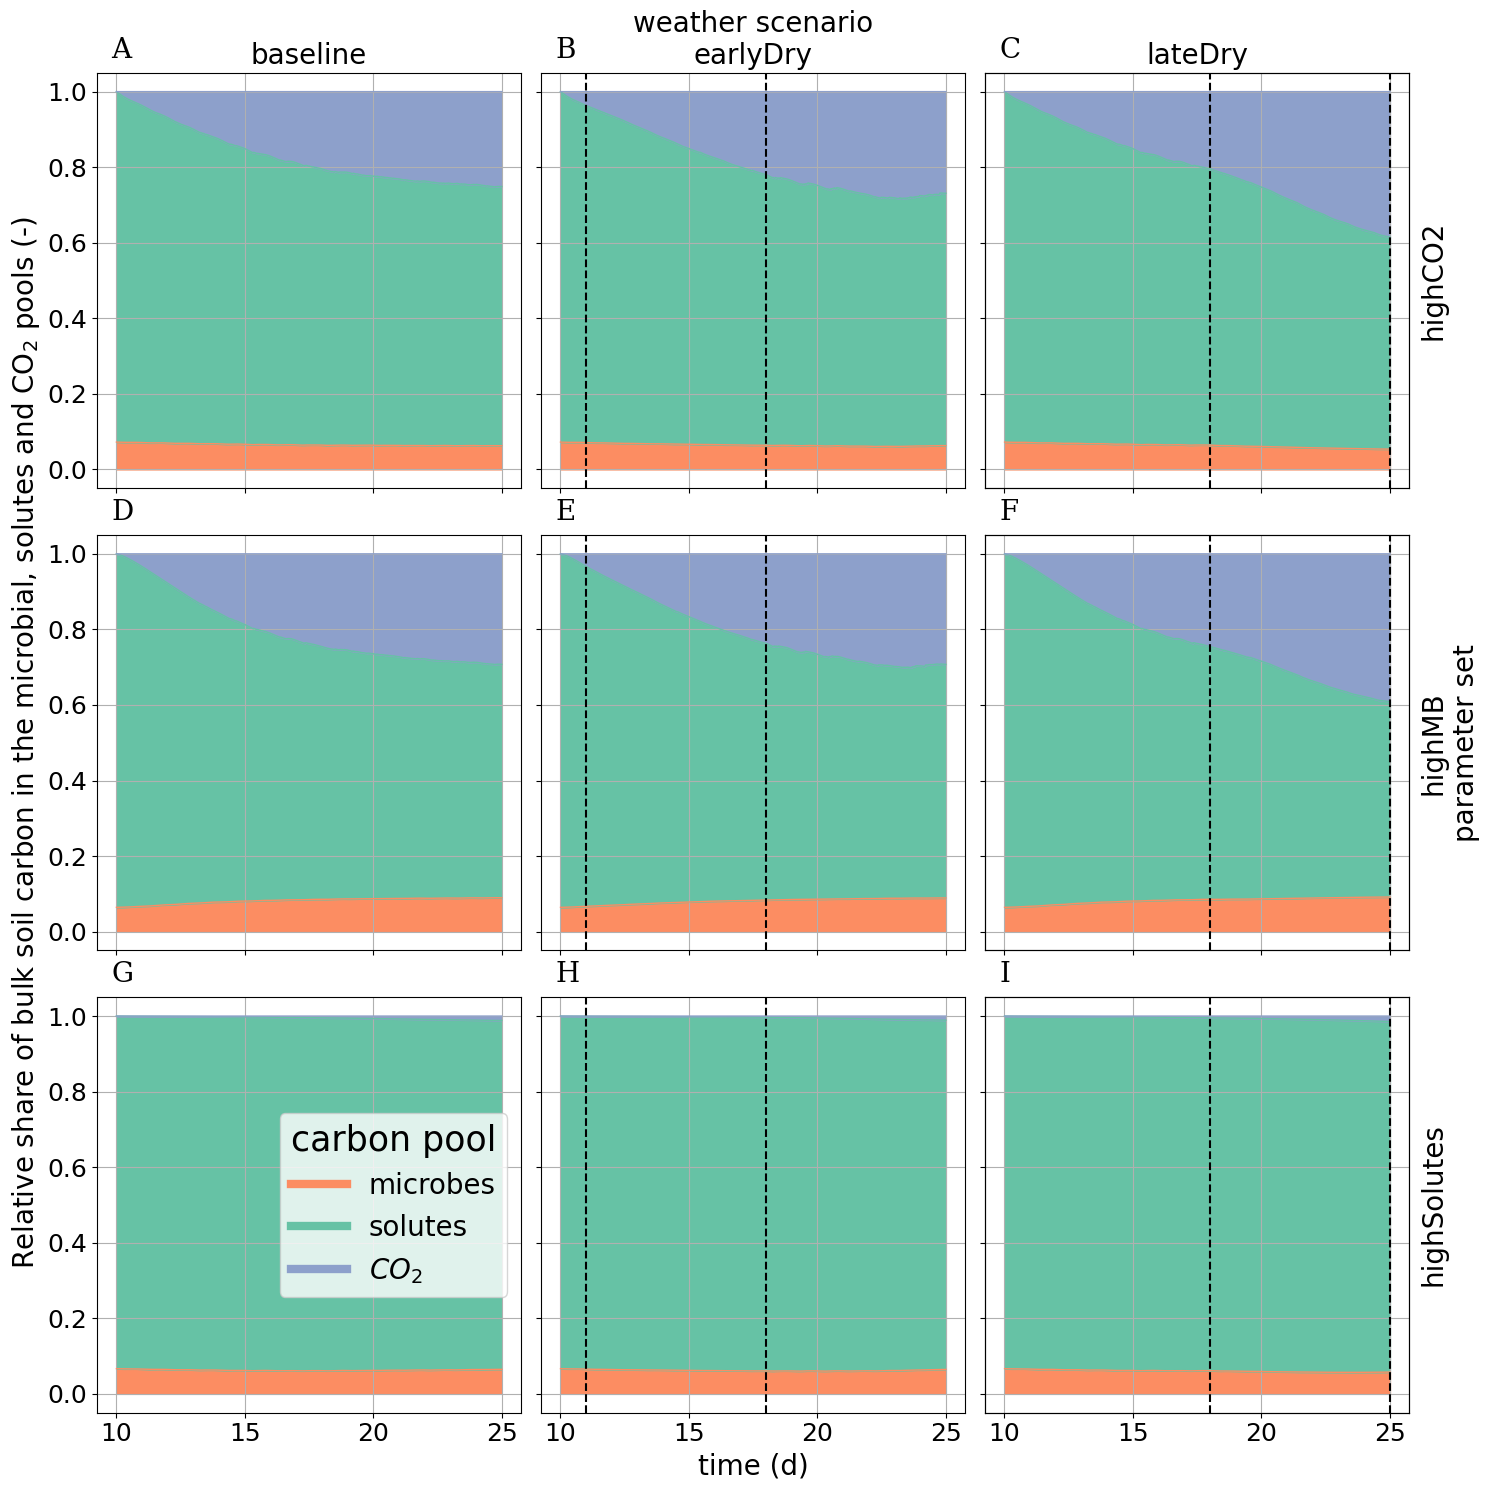

In [11]:
cumsum_and_plotAllcontentvstime(dataframe_=dfbulksoilrel,
                                ylab="Relative share of bulk soil carbon in the microbial, solutes and CO$_2$ pools (-)",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribBulk',vividlim=-1,
                                    legendLabel={},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

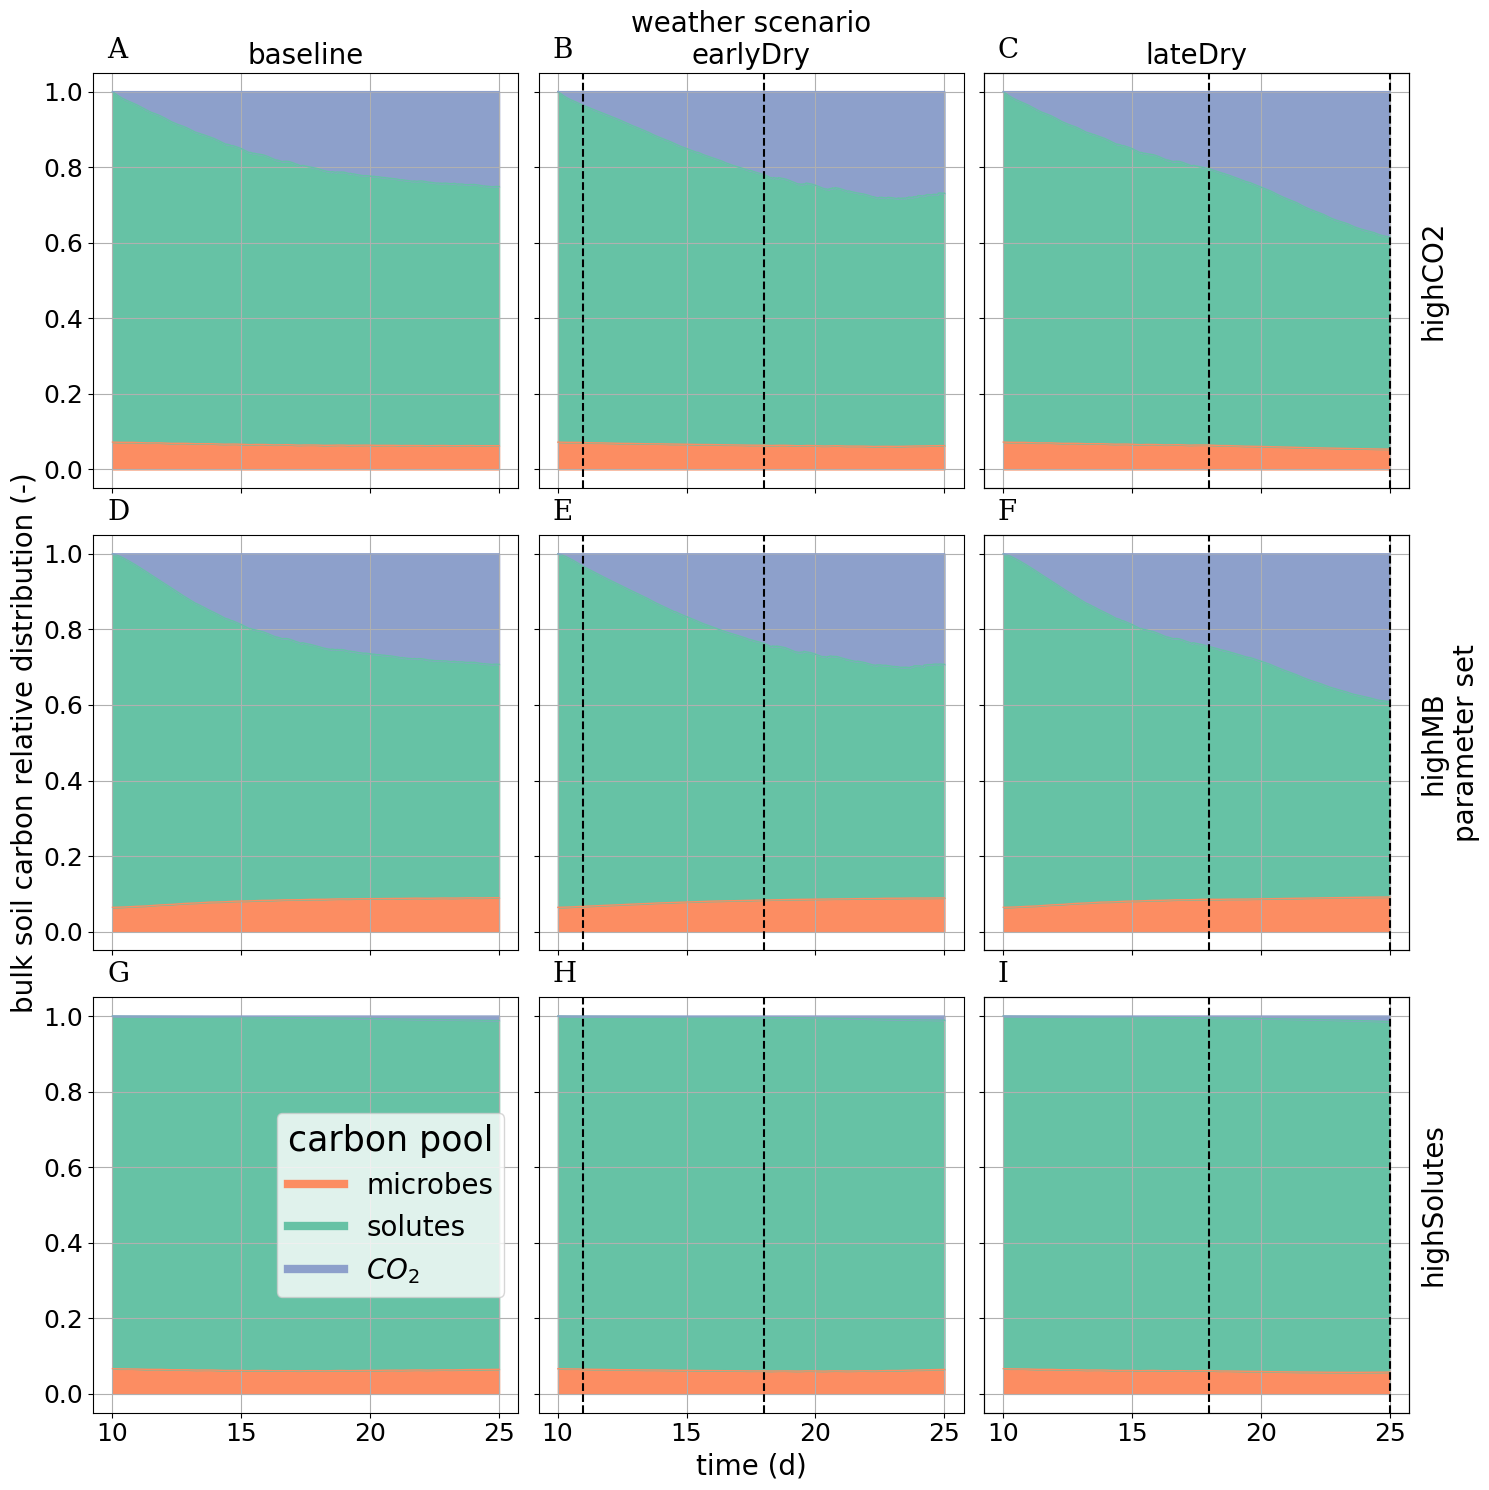

In [12]:
cumsum_and_plotAllcontentvstime(dataframe_=dfbulksoilrel,
                                ylab="bulk soil carbon relative distribution (-)",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribBulk',vividlim=-1,
                                    legendLabel={},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

In [13]:
dfmeanTotrel18 = dfbulksoilrel.loc[abs(dfbulksoilrel['time']-18.)==min(abs(dfbulksoilrel['time']-18.)),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes']].copy().reset_index()
dfmeanTotrel25 = dfbulksoilrel.loc[dfbulksoilrel['time']==max(dfbulksoilrel['time']),
                [ 'pSetscenario','$CO_2$','microbes', 'solutes']].copy().reset_index()
dfmeanTotrel1825 = dfbulksoilrel.loc[(abs(dfbulksoilrel['time']-18.)==min(abs(dfbulksoilrel['time']-18.))
                                    )|(
    dfbulksoilrel['time']==max(dfbulksoilrel['time'])
),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes', 'time']].copy().reset_index(drop=True)
dfmeanTotrel1825['time'] = pd.to_numeric(dfmeanTotrel1825['time'], downcast='integer')
dfmeanTotrel1825[['$CO_2$','microbes', 'solutes']] *= 100.

df = dfmeanTotrel1825.copy()
# Round the scaled values
df['CO2_scaled'] = df['$CO_2$'].round().astype(int)
df['microbes_scaled'] = df['microbes'].round().astype(int)
df['solutes_scaled'] = df['solutes'].round().astype(int)

df['sum'] = df['CO2_scaled'] + df['microbes_scaled'] + df['solutes_scaled']


# Ensure that the sum of the scaled values is exactly 100
def adjust_to_100(row):
    idData = np.where(row.index == 'CO2_scaled')[0][0]
    total = row['CO2_scaled'] + row['microbes_scaled'] + row['solutes_scaled']
    diff = 100 - total
    assert (abs(diff) == 1) or (abs(diff) == 0)
    #print(row[1])
    decidata = np.array([
        row['$CO_2$'] - row['CO2_scaled'] ,
        row['microbes'] - row['microbes_scaled'] ,
        row['solutes'] - row['solutes_scaled'] ]
    )
    # Adjust the largest value to compensate for the rounding difference
    if diff == -1: # need to remove 
        posrow = np.where(decidata==min(decidata))[0][0]
        
    if diff == 1: # need to remove 
        posrow = np.where(decidata==max(decidata))[0][0]
    
    if diff != 0:        
        #print('coucouA',diff,'index',idData + posrow,'sel',row.values[idData + posrow])
        row.values[idData + posrow] += diff
        #print('coucouB',diff,'sel',row.values[idData + posrow])
    return row

df_scaled = df.apply(adjust_to_100, axis=1)


df_scaled['sum_scaled'] = df_scaled['CO2_scaled'] + df_scaled['microbes_scaled'] + df_scaled['solutes_scaled']
df_scaled[['$CO_2$','microbes', 'solutes']] = df_scaled[['CO2_scaled','microbes_scaled','solutes_scaled']]
df_scaled_relbulk = df_scaled.drop(columns=['CO2_scaled','microbes_scaled','solutes_scaled', "sum", "sum_scaled"])

# Pivot the table
df_wide_relbulk = df_scaled_relbulk.pivot_table(index=['pSet', 'scenario'], columns='time', values=['$CO_2$', 'microbes', 'solutes'])

df_wide_relbulk.style.to_latex('relDistribBulkSoil_1825.tex', sparse_index=False)

In [37]:
dfbulksoilrel.loc[dfbulksoilrel['time']==max(dfbulksoilrel['time']),
                [ 'scenario', 'pSet', '$CO_2$','microbes', 'solutes'
                ]]#.to_numpy()
#,'solutes', '$CO_2$'

,scenario,pSet,$CO_2$,microbes,solutes
9711,baseline,5,0.257611,0.062340,0.680049
9712,baseline,44,0.296124,0.089528,0.614348
9713,baseline,61,0.013714,0.066012,0.920274
9714,earlyDry,5,0.296718,0.060447,0.642835
9715,earlyDry,44,0.319967,0.089629,0.590404
9716,earlyDry,61,0.012593,0.064297,0.923110
9717,lateDry,5,0.424785,0.050597,0.524617
9718,lateDry,44,0.423288,0.092268,0.484444
9719,lateDry,61,0.017069,0.056735,0.926196


In [14]:
dfbulksoilrelout = dfbulksoilrel.loc[dfbulksoilrel['time']==max(dfbulksoilrel['time']),
                [ 'scenario', 'pSet', '$CO_2$','microbes', 'solutes'
                ]].copy()

In [15]:
dfmeanTotrelout = dfmeanTotrel.loc[dfmeanTotrel['time']==max(dfbulksoilrel['time']),
                [ 'scenario', 'pSet', '$CO_2$','microbes', 'solutes'
                ]].copy()

In [16]:
dfbulksoilrelout

,scenario,pSet,$CO_2$,microbes,solutes
9711,baseline,5,0.251352,0.062662,0.685986
9712,baseline,44,0.292539,0.089431,0.618030
9713,baseline,61,0.011590,0.064771,0.923639
9714,earlyDry,5,0.269132,0.062777,0.668090
9715,earlyDry,44,0.292673,0.089001,0.618326
9716,earlyDry,61,0.010868,0.064706,0.924426
9717,lateDry,5,0.385148,0.053600,0.561251
9718,lateDry,44,0.391547,0.091541,0.516913
9719,lateDry,61,0.014294,0.057561,0.928144


In [17]:
dfbulksoilrelout[['$CO_2$','microbes', 'solutes']]*=100.
dfmeanTotrelout[['$CO_2$','microbes', 'solutes']]*=100.

In [18]:
dfmeanTotrelout

,scenario,pSet,$CO_2$,microbes,solutes
9711,baseline,44,58.828770,9.798129,31.373102
9712,baseline,5,56.548295,3.617388,39.834317
9713,baseline,61,3.915831,6.808330,89.275839
9714,earlyDry,44,65.064716,10.251433,24.683850
9715,earlyDry,5,68.377970,3.155069,28.466960
9716,earlyDry,61,4.018421,6.793163,89.188416
9717,lateDry,44,77.902030,10.106383,11.991586
9718,lateDry,5,83.094066,1.898599,15.007335
9719,lateDry,61,3.246889,3.841371,92.911739


In [19]:
dfbulksoilrelout.style.to_latex('relDistribBulkSoil.tex', sparse_index=False)

In [20]:
dfmeanTotrelout.style.to_latex('relDistribPeri.tex', sparse_index=False)

###################

In [21]:
dfbulksoil = pd.read_pickle('./soil3dData.pkl')
dfbulksoil = dfbulksoil[dfbulksoil['gotR']].copy().reset_index()
dfbulksoil[[ 'cs', 'cl']
           ] =dfbulksoil[[ 'cs', 'cl'] ].mul(dfbulksoil['theta'], axis=0)
dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ]
           ] =dfbulksoil[[ 'cs', 'css','cl','cc','co' ,'co2'] ].mul(dfbulksoil['volscv'], axis=0)
dfbulksoil['totC']=dfbulksoil[[ 'cs', 'css','cl','cc','co','co2' ] ].sum(axis=1)
dfbulksoil = dfbulksoil.groupby(["time", "scenario", "pSet"])[ [ 'cs', 'css','cl','cc','co','co2','totC' ] ].agg('sum').reset_index()


In [22]:
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
from matplotlib.transforms import ScaledTranslation
l_styles = {5:'-',44:'--',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#8da0cb',  # Blue
    'earlyDry':  '#66c2a5' ,  # Green
    'lateDry': '#fc8d62'  # red
}


color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=6, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=6, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=6, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=6, label="highCO2"),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=6, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=6, label="highMB"),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=6, label="highSolutes")
]

def dotheplot(toplot, cumsum,df, sizerows,sizecols_,namesyaxes=None,ncols=1,factor = 1000,
              maxTime = None, 
              indexlegend1=0, indexlegend2=0):
    nrows = len(toplot)
    #ncols = 3
    scenarios = [ "baseline","earlyDry", "lateDry"]
    
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols_))  # 2 rows, 2 columns
    ax_ = ax
    for pset_ in [5,44,61]:
        for scenario_ in scenarios:
            dd = df[(df['scenario']==scenario_)&(df['pSet']==pset_)].copy()
            for rowid, tipi in enumerate(toplot): 
                
                if ncols > 1:
                    colid = np.where(scenario_==np.array(scenarios))[0][0]
                else:
                    colid = 0
                rot = 0
                unit=" (mmol C)"
                if (tipi == "trans" )or (tipi =='psiXyl'):
                    factor = cm3tommol
                    unit = " (cm3)"

                if tipi == "psiXyl":
                    factor = 1.
                    rot =30
                    unit = " (cm)"

                ddd = dd[tipi]*factor
                tts = dd['time']
                if not cumsum:
                    tts = dd['time'][1:]
                    ddd = np.diff(ddd)*4


                ax_.plot( tts,ddd,linewidth=3,
                             #label=f'{i}',
                             c=c_styles[dd['scenario'].unique()[0]],
                             linestyle=l_styles[int(dd['pSet'].unique()[0])]
                        )


    ax_.tick_params(axis='both', which='major', labelsize=18)
    ax_.tick_params(axis='y', which='major', labelrotation=rot, labelsize=18)
    if colid == 0:
        if namesyaxes is not None:
            if tipi == "psiXyl":
                ax_.set_ylabel(namesyaxes[tipi]+unit, fontsize=20)
            else:
                ax_.set_ylabel("cumulative C (mmol C)\nused for\n"+namesyaxes[tipi], fontsize=20)
        else:
            ax_.set_ylabel(tipi+unit, fontsize=20)
    if rowid == 0 and ncols > 1:
        ax_.set_title(scenario_)
    if rowid == nrows-1:
        ax_.set_xlabel('time (d)', fontsize=20)
    if True:
        if scenario_ == "lateDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=25, color='k', linestyle='--')
        if scenario_ == "earlyDry":
            ax_.axvline(x=18, color='k', linestyle='--')
            ax_.axvline(x=11, color='k', linestyle='--')
    if maxTime is not None:
        ax_.set_xlim(10, maxTime)
    if False:
        ax_.legend(handles=color_legend_elements, 
                                                   fontsize=20,title_fontsize='25', title='scenario', 
                                                   loc='upper center',  ncol=3)#bbox_to_anchor=(0.5, -0.15),

        ax_.legend(handles=linestyle_legend_elements, 
                                                   fontsize=20,title_fontsize='25', title='parameter set', 
                                                   loc='upper center',  ncol=3)#bbox_to_anchor=(0.5, -0.3),

    print('color_legend_elements')
    ax_.add_artist(plt.legend(handles=color_legend_elements, 
                                                              fontsize=20, title='scenario', 
                                                               title_fontsize='25',
                                                              loc='center left',# bbox_to_anchor=anchor1,#(0.5, -0.15), 
                                                              ncol=3, framealpha=1))
    print('linestyle_legend_elements')
    ax_.add_artist(plt.legend(handles=linestyle_legend_elements, 
                                                              fontsize=20, title='parameter set', 
                                                               title_fontsize='25',
                                                              loc='upper left',# bbox_to_anchor=anchor2,#(0.5, -0.3), 
                                                              ncol=3, framealpha=1))

        #ax_.legend() 
    index = rowid * ncols + colid
    # Get the corresponding letter label
    label = string.ascii_uppercase[index]
    ax_.annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='20', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
    plt.tight_layout()

color_legend_elements
linestyle_legend_elements


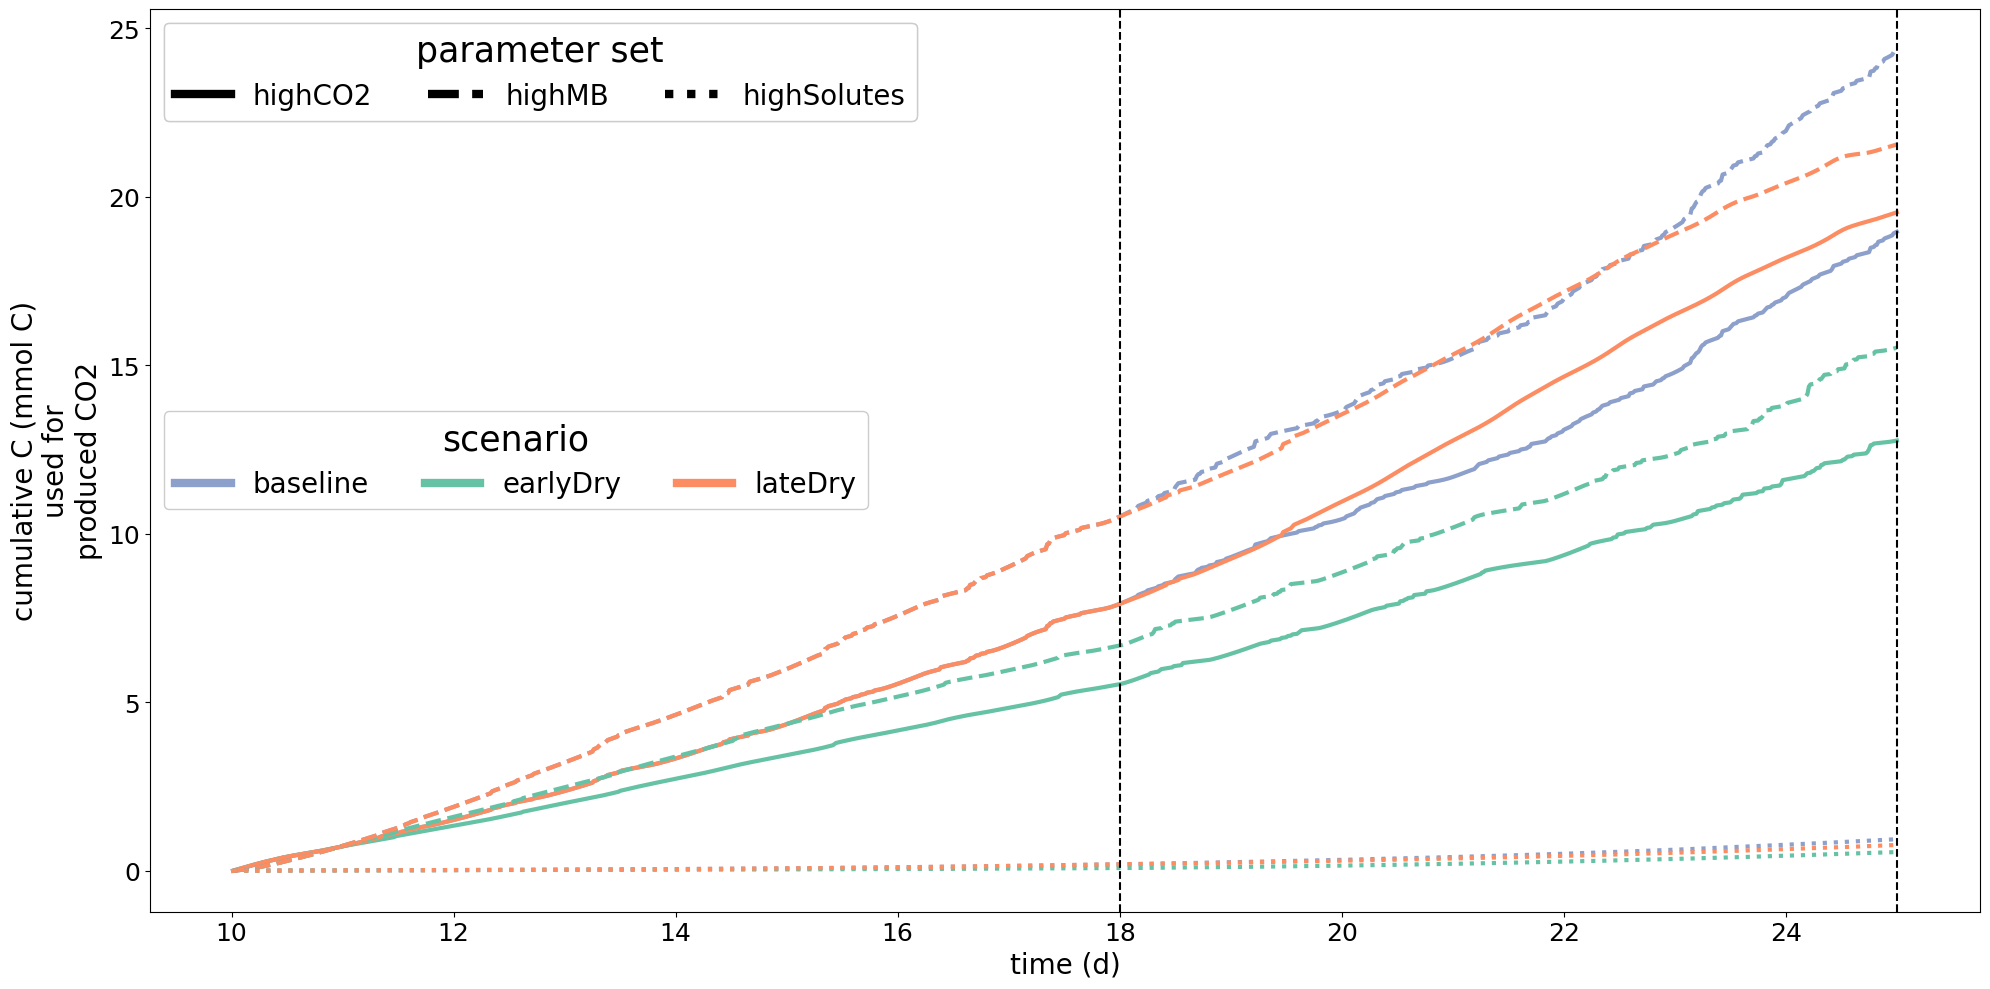

In [23]:

dotheplot(toplot =  ['co2'],df = dfbulksoil,
          namesyaxes={'co2': "produced CO2"},
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)

color_legend_elements
linestyle_legend_elements


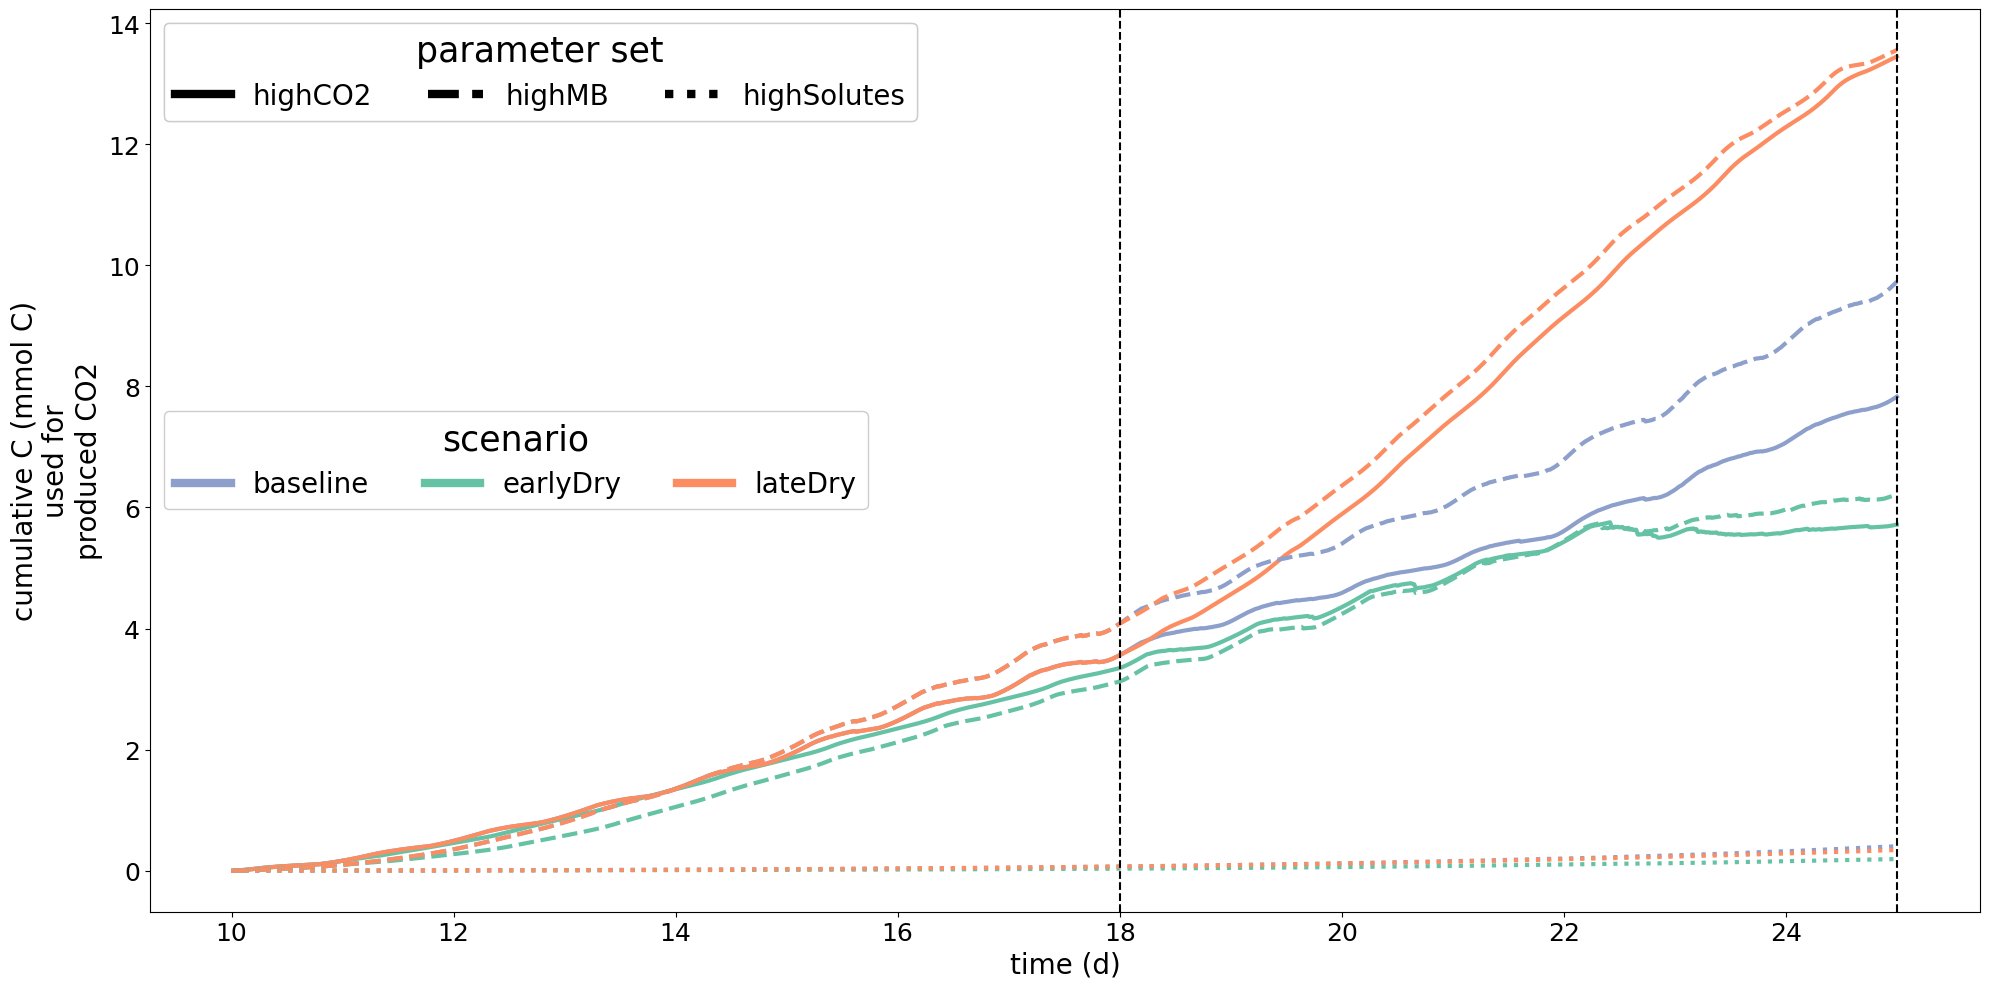

In [24]:

dfmeanTot = dfmeanTot.astype({'pSet': int
                })
dotheplot(toplot =  ['partialQ_co2'],df = dfmeanTot,
          namesyaxes={'partialQ_co2': "produced CO2"},
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)


In [25]:
dfbulksoil1825 = dfbulksoil.copy()

dfbulksoil1825['microbes'] = dfbulksoil1825[ ['co','cc']].sum(axis=1)
dfbulksoil1825['solutes'] = dfbulksoil1825[ ['cs', 'css','cl']].sum(axis=1)
dfbulksoil1825['$CO_2$'] =  dfbulksoil1825['co2']
dfbulksoil1825 = dfbulksoil1825.loc[(abs(dfbulksoil1825['time']-18.)==min(abs(dfbulksoil1825['time']-18.))
                                )|(
    dfbulksoil1825['time']==max(dfbulksoil1825['time'])),
                [ 'pSet','scenario','$CO_2$', 'microbes', 'solutes', 'time']].copy().reset_index(drop=True)

dfbulksoil1825['time'] = pd.to_numeric(dfbulksoil1825['time'], downcast='integer')
for namdtemp in ['$CO_2$', 'microbes', 'solutes']:
    dfbulksoil1825[namdtemp]*=1000
    dfbulksoil1825[namdtemp]=dfbulksoil1825[namdtemp].round(decimals=1)

# Pivot the table
df_wide_absbulk = dfbulksoil1825.pivot_table(index=['pSet', 'scenario'], columns='time', values=['$CO_2$', 'microbes', 'solutes'])

df_wide_absbulk.style.to_latex('absBulkSoil_1825.tex', sparse_index=False)

In [26]:
dfperi1825abs = dfmeanTot.copy()

dfperi1825abs['microbes'] = dfperi1825abs[ ['partialQ_coa', 'partialQ_cod', 'partialQ_cca', 'partialQ_ccd']].sum(axis=1)
dfperi1825abs['solutes'] = dfperi1825abs[ ['partialQ_cssoil', 'partialQ_css','partialQ_clsoil']].sum(axis=1)
dfperi1825abs['$CO_2$'] =  dfperi1825abs['partialQ_co2']
dfperi1825abs = dfperi1825abs.loc[(abs(dfperi1825abs['time']-18.)==min(abs(dfperi1825abs['time']-18.))
                                )|(
    dfperi1825abs['time']==max(dfperi1825abs['time'])),
                [ 'pSet','scenario','$CO_2$', 'microbes', 'solutes', 'time']].copy().reset_index(drop=True)

dfperi1825abs['time'] = pd.to_numeric(dfperi1825abs['time'], downcast='integer')
for namdtemp in ['$CO_2$', 'microbes', 'solutes']:
    dfperi1825abs[namdtemp]*=1000
    dfperi1825abs[namdtemp]=dfperi1825abs[namdtemp].round(decimals=1)

# Pivot the table
df_wide_absperi = dfperi1825abs.pivot_table(index=['pSet', 'scenario'], columns='time', values=['$CO_2$', 'microbes', 'solutes'])

df_wide_absperi.style.to_latex('absperi_1825.tex', sparse_index=False)

In [27]:
df_scaled_rel006['scale']="perirhizal$_{0.06}$"
df_scaled_relbulk['scale']="bulk soil"
df_bigrel = pd.concat([df_scaled_rel006,df_scaled_relbulk], ignore_index=True) 

df_wide_relall = df_bigrel.pivot_table(index=['pSet', 'scenario'], columns=['scale','time'], values=['$CO_2$', 'microbes', 'solutes'])

df_wide_relall.style.to_latex('relDistribAll_1825.tex', sparse_index=False)

NameError: name 'df_scaled_rel006' is not defined

In [101]:
df_wide_relallbis = df_wide_relall.swaplevel(0, 1, axis=1).sort_index(axis=1)
df_wide_relallbis.style.to_latex('relDistribAllbis_1825.tex', sparse_index=False)

In [148]:
dfall = pd.read_pickle('./soil3dData.pkl')
#dfbulksoil = dfbulksoil[dfbulksoil['gotR']].copy().reset_index()
dfall[[ 'cs', 'cl']
           ] =dfall[[ 'cs', 'cl'] ].mul(dfall['theta'], axis=0)
dfall[[ 'cs', 'css','cl','cc','co','co2' ]
           ] =dfall[[ 'cs', 'css','cl','cc','co' ,'co2'] ].mul(dfall['volscv'], axis=0)
dfall['totC']=dfall[[ 'cs', 'css','cl','cc','co','co2' ] ].sum(axis=1)
dfall = dfall.groupby(["time", "scenario", "pSet"])[ [ 'cs', 'css','cl','cc','co','co2','totC' ] ].agg('sum').reset_index()

color_legend_elements
linestyle_legend_elements


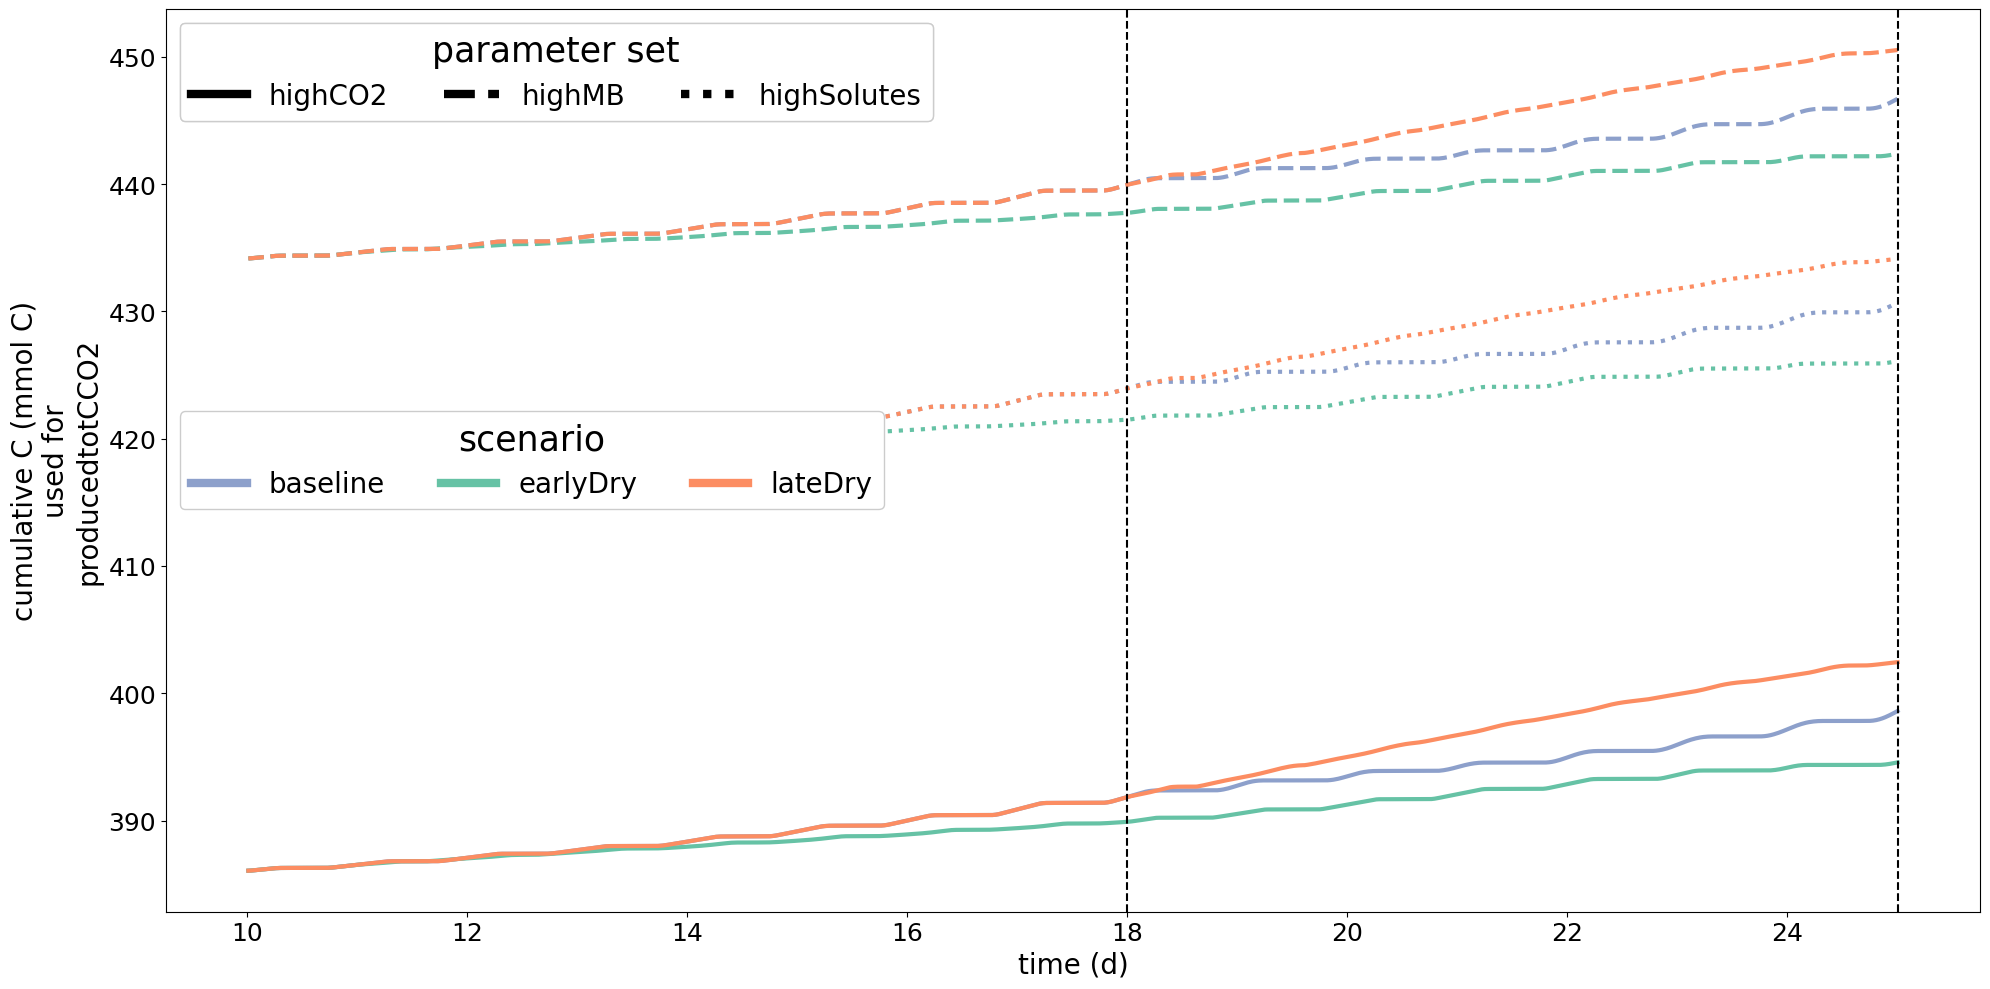

In [137]:

dotheplot(toplot =  ['totC'],df = dfall,
          namesyaxes={'totC': "producedtotCCO2"},
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)


color_legend_elements
linestyle_legend_elements


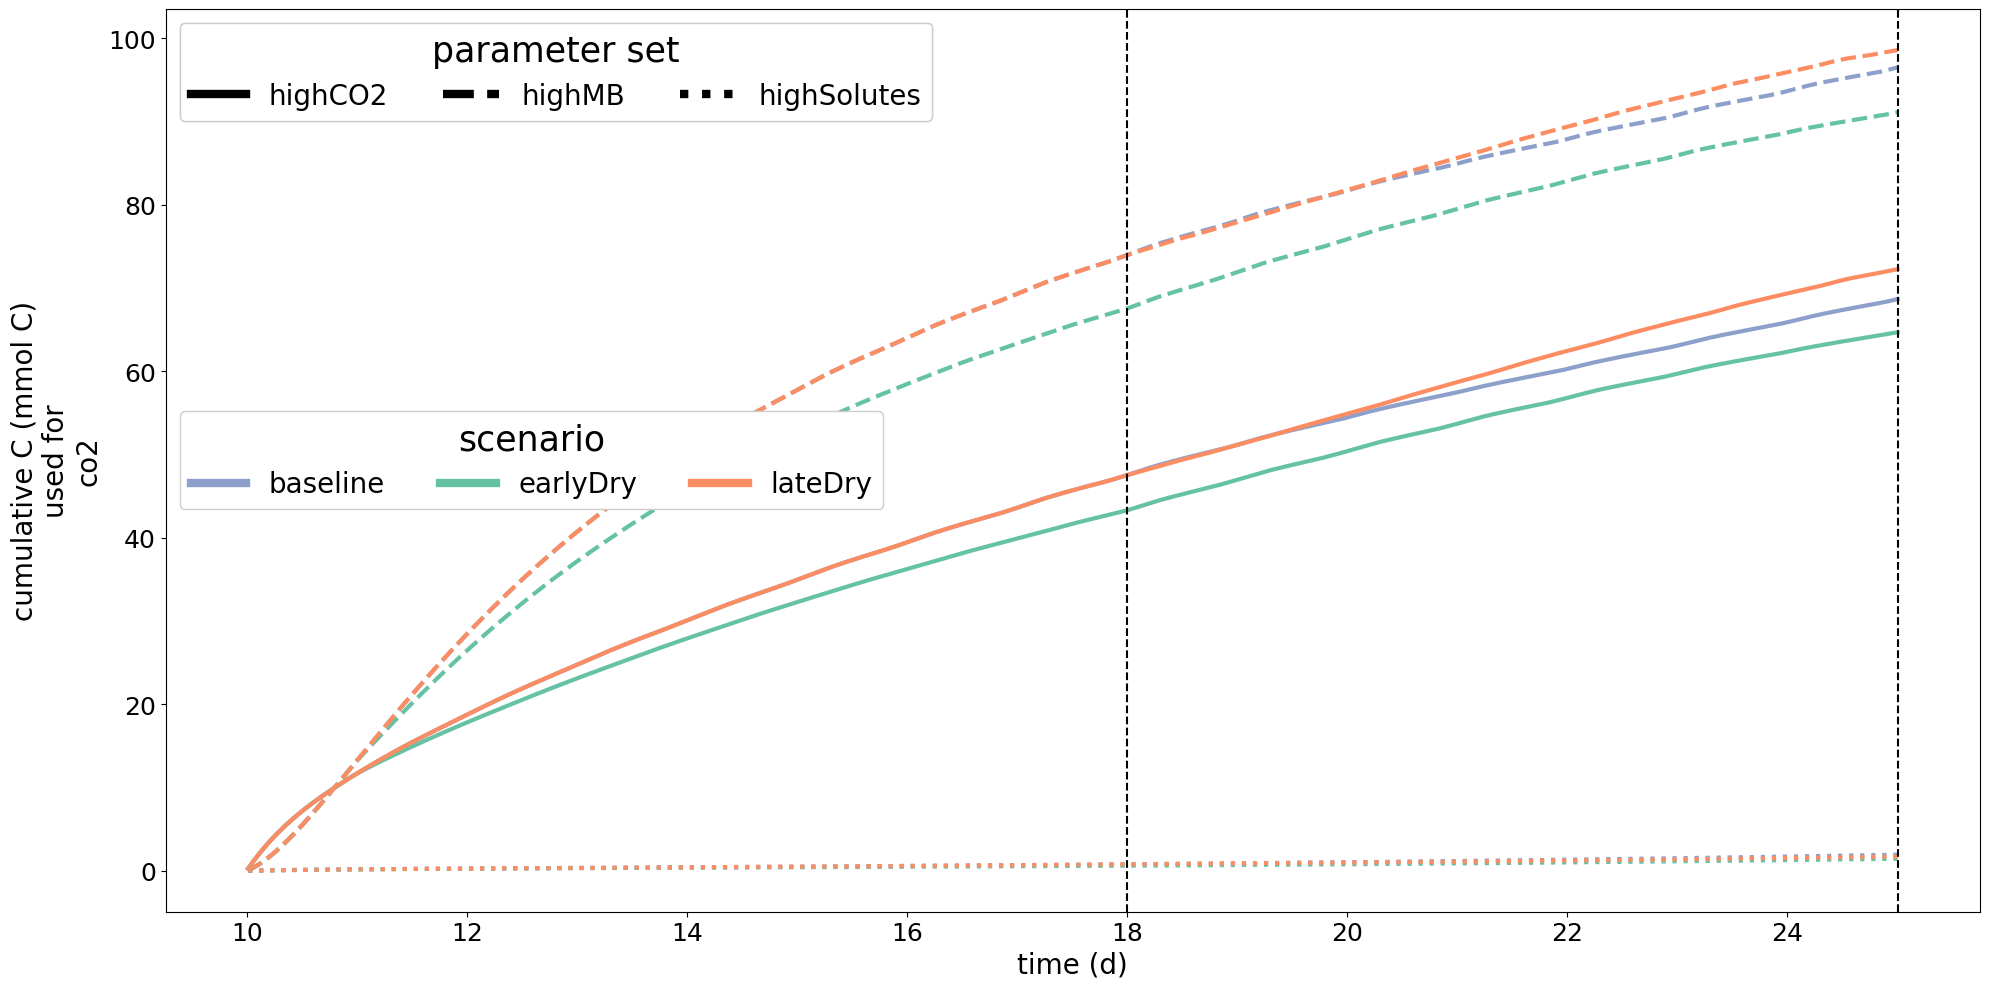

In [138]:

dotheplot(toplot =  ['co2'],df = dfall,
          namesyaxes={'co2': "co2"},
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)

In [149]:
#dfall['relCO2'] = dfall['co2']/dfall['totC']
dfall[ [ 'csrel', 'cssrel','clrel','ccrel','corel','co2rel','totCrel' ] 
            ] =dfall[ [ 'cs', 'css','cl','cc','co','co2','totC' ]  ].div(dfall['totC'], axis=0)

color_legend_elements
linestyle_legend_elements


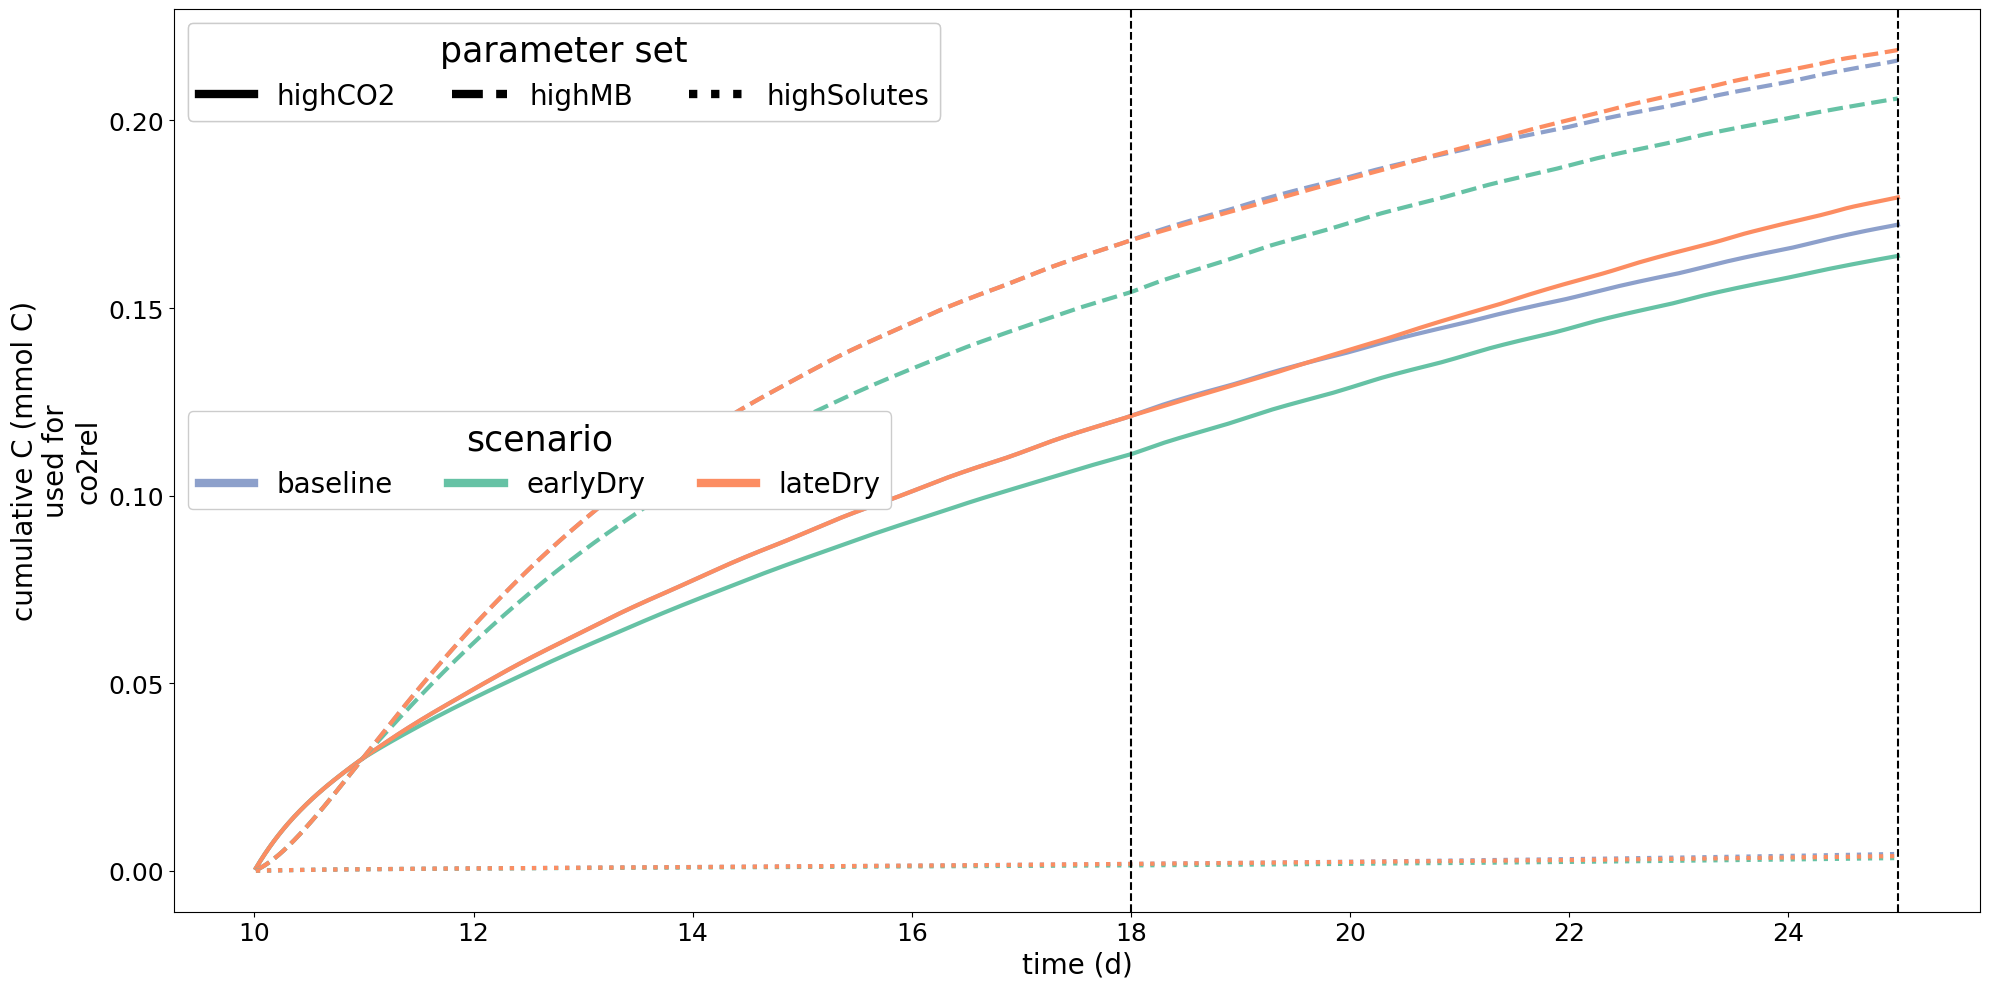

In [150]:

dotheplot(toplot =  ['co2rel'],df = dfall,
          namesyaxes={'co2rel': "co2rel"},factor = 1.,
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)

color_legend_elements
linestyle_legend_elements
color_legend_elements
linestyle_legend_elements


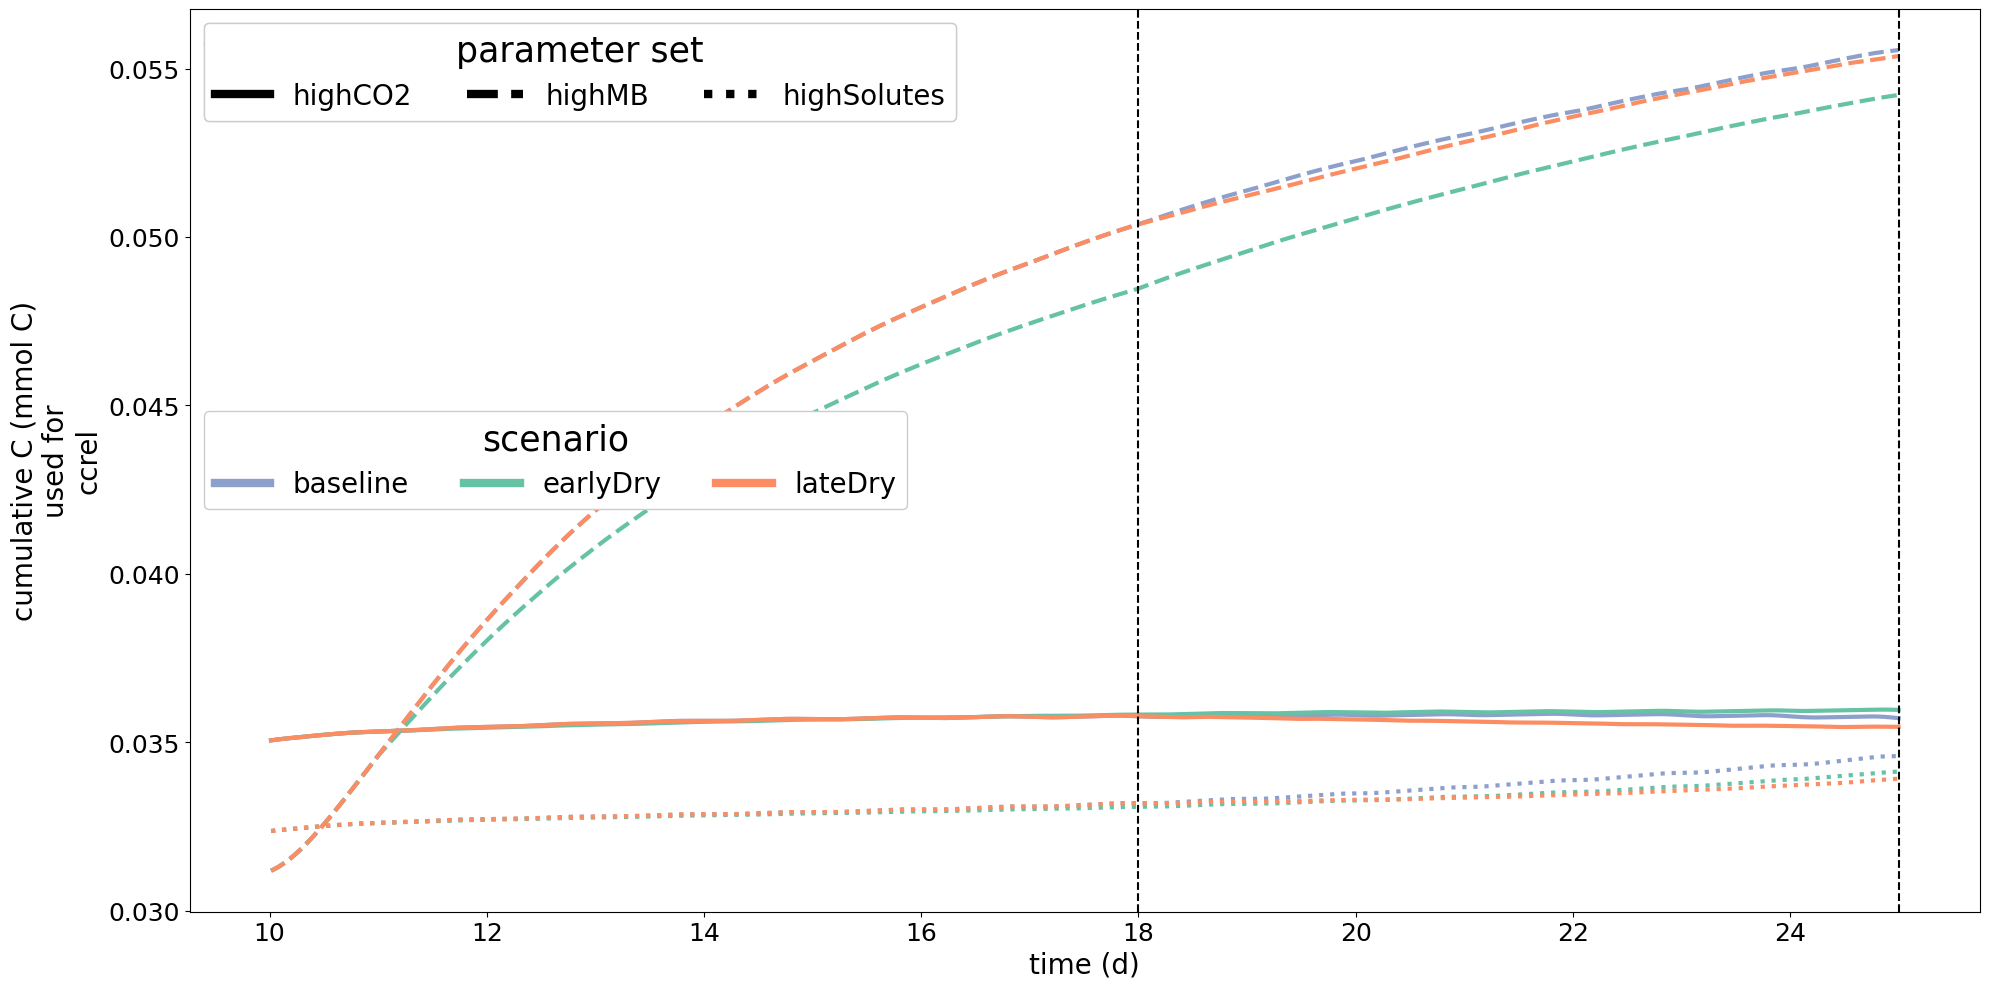

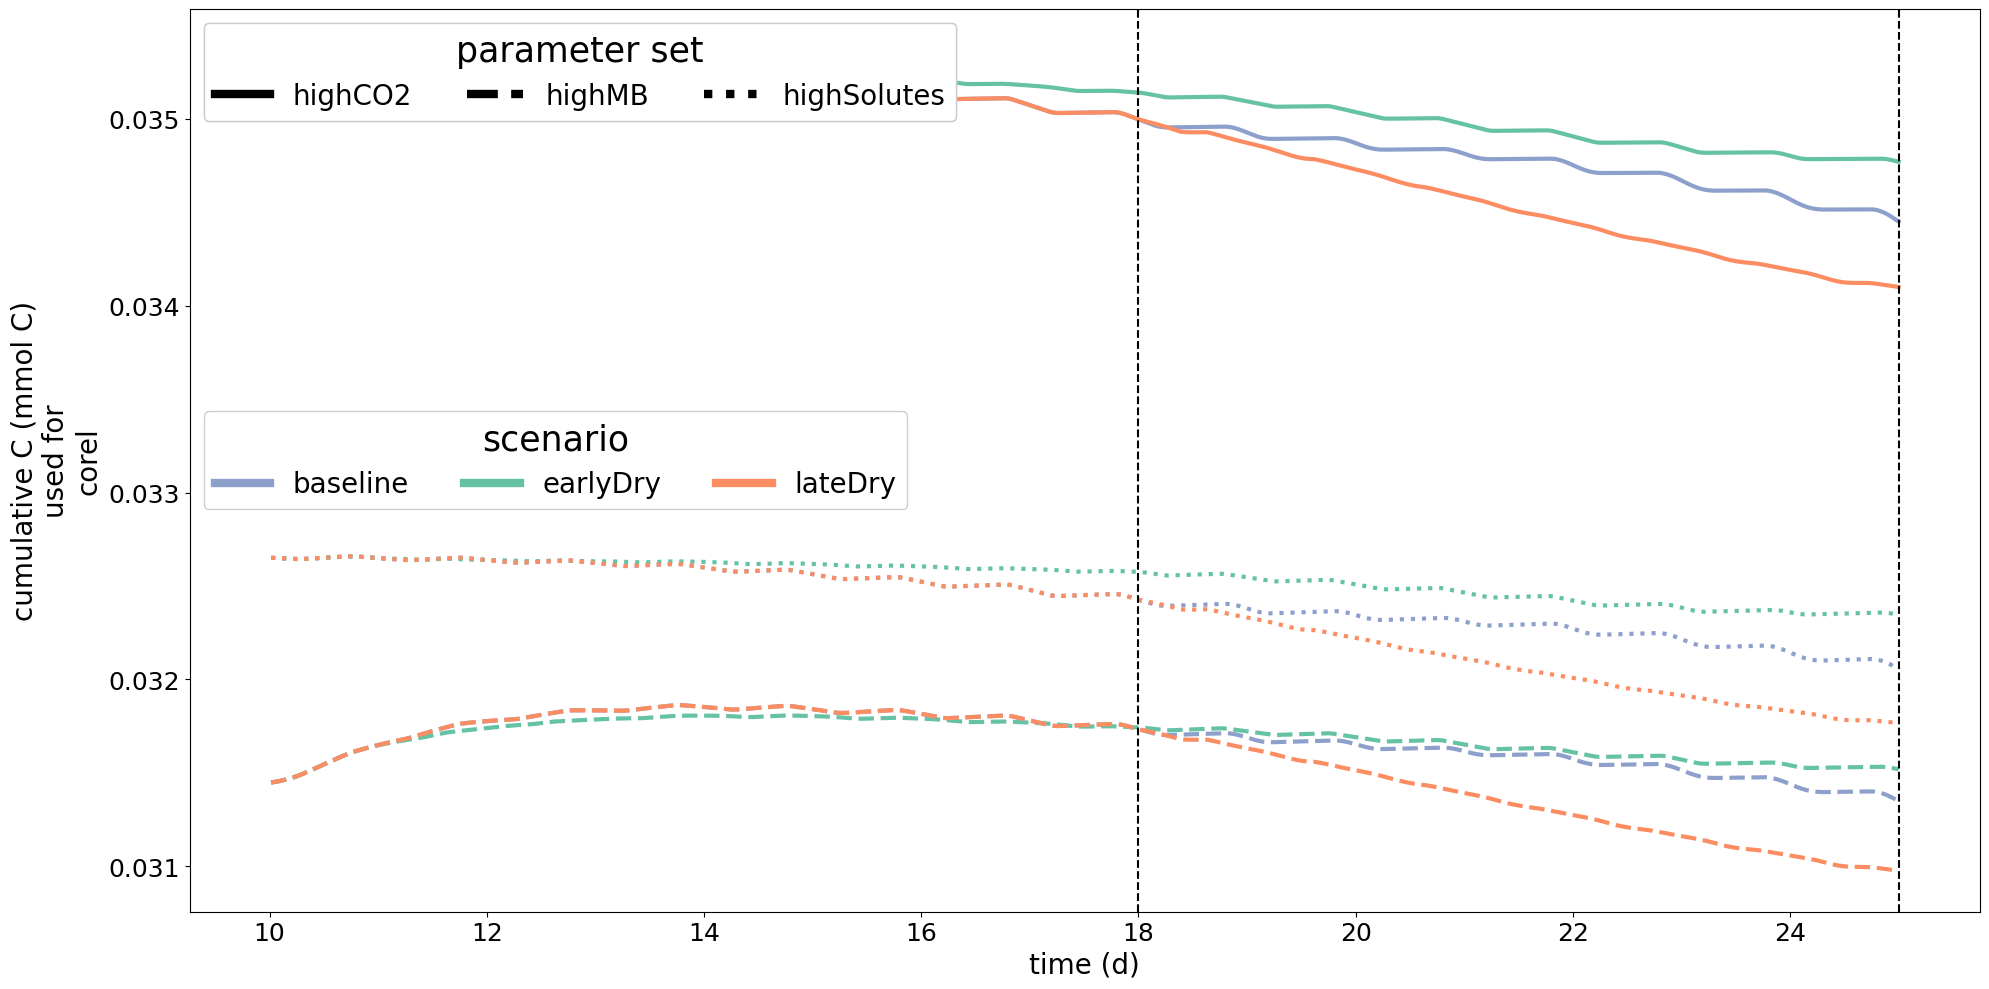

In [152]:

dotheplot(toplot =  ['ccrel'],df = dfall,
          namesyaxes={'ccrel': "ccrel"},factor = 1.,
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)
dotheplot(toplot =  ['corel'],df = dfall,
          namesyaxes={'corel': "corel"},factor = 1.,
          cumsum=True, sizerows=20,sizecols_=10,ncols=1, indexlegend1=0, indexlegend2=0)

In [165]:

dfall['microbes'] = dfall[ ['co','cc']].sum(axis=1)
dfall['solutes'] = dfall[ ['cs', 'css','cl']].sum(axis=1)
dfall['$CO_2$'] =  dfall['co2']
dfall['pSetscenario'] =np.array( dfall['pSet'], dtype=str)+dfall['scenario']
dfall['pSet']=dfall['pSet'].astype(str)
dfall['scale']="macroscale"
dfallrel = dfall.copy()
dfallrel['microbes'] = dfall[ ['corel','ccrel']].sum(axis=1)
dfallrel['solutes'] = dfall[ ['csrel', 'cssrel','clrel']].sum(axis=1)
dfallrel['$CO_2$'] =  dfall['co2rel']


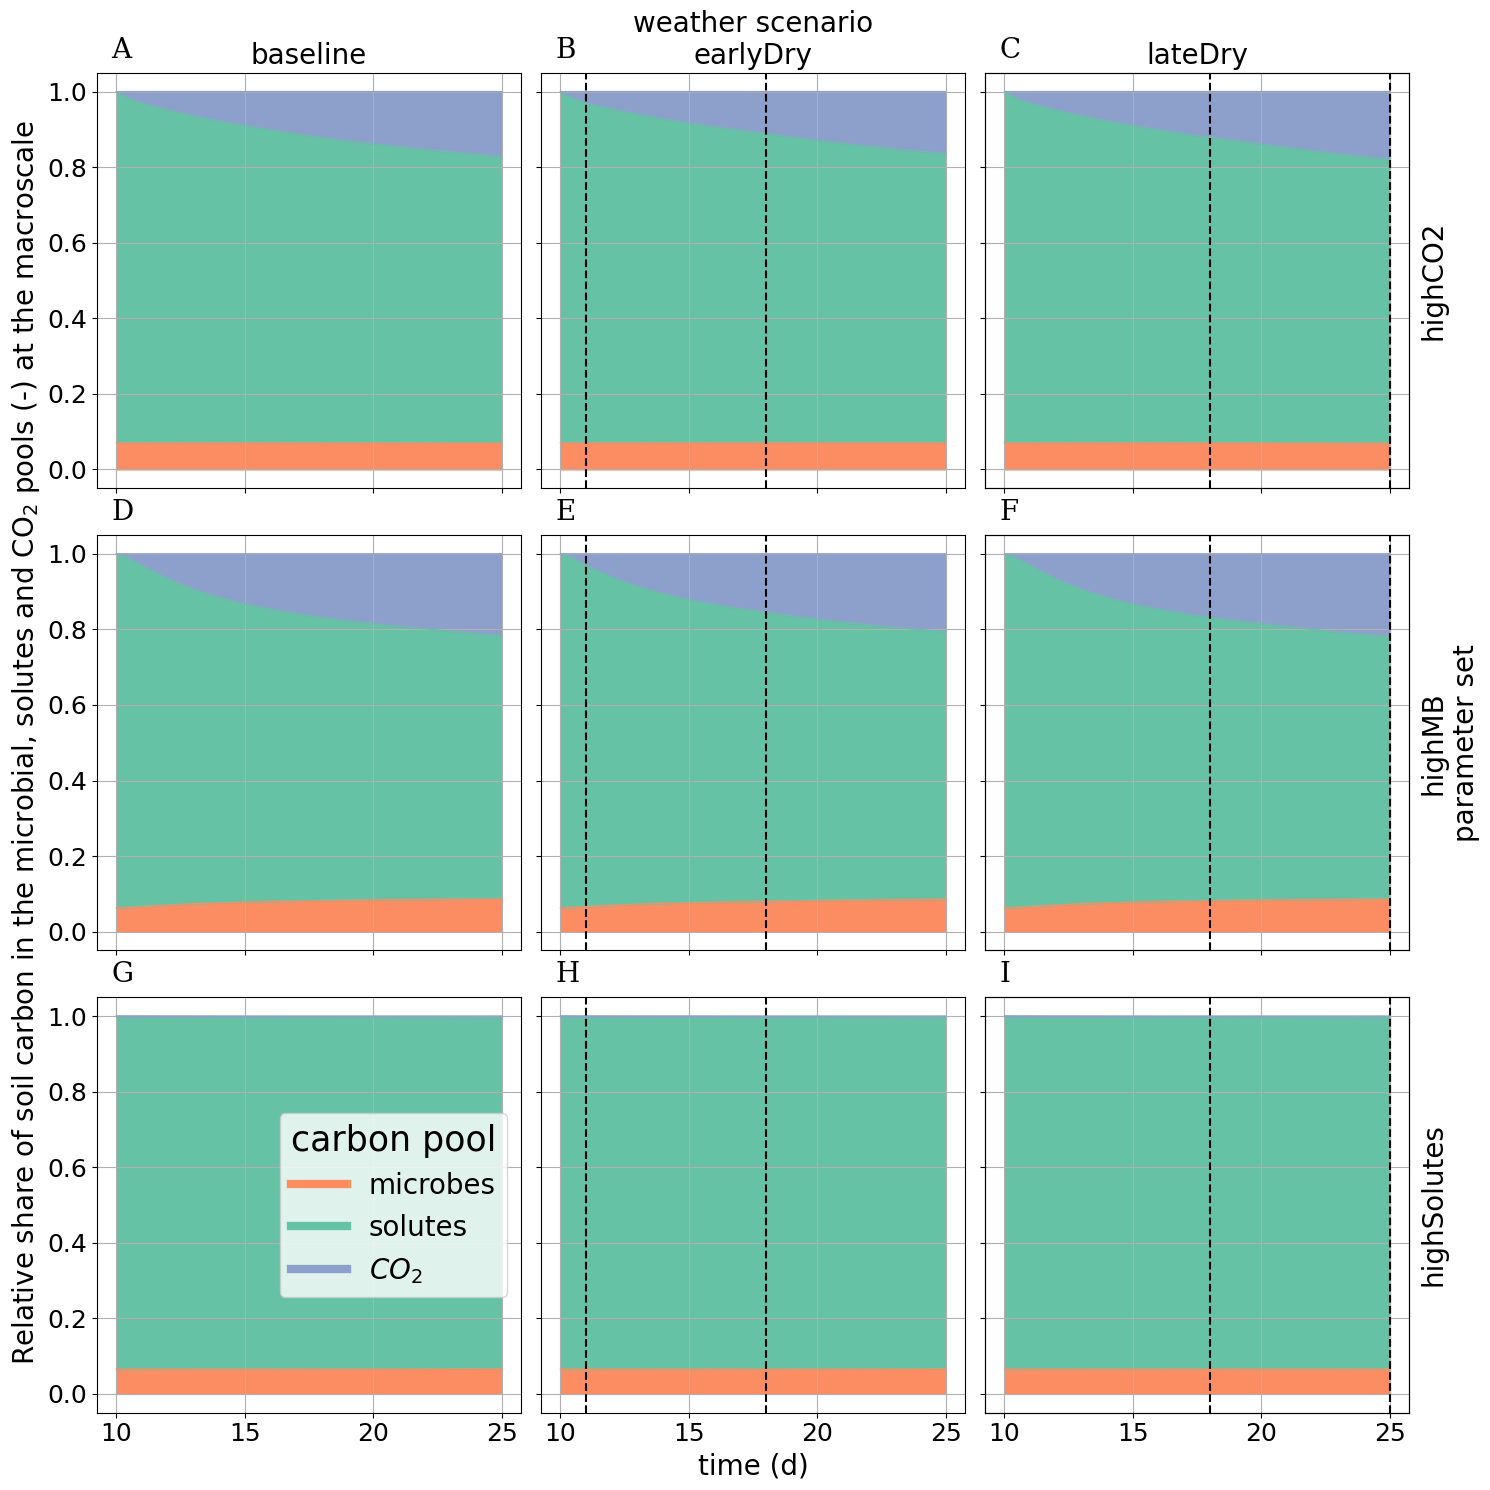

In [164]:
cumsum_and_plotAllcontentvstime(dataframe_=dfallrel,
                                ylab="Relative share of soil carbon in the microbial, solutes and CO$_2$ pools (-) at the macroscale",
                                xlab="time (d)",
                   dosave=True, doshow=True, savedir='./', 
                                saveName='relpooldistribMacro',vividlim=-1,
                                    #legendLabel={'microbesrel':'microbes','solutesrel':'solutes','$CO_2$rel':'$CO_2$'},
                                depVars= ['microbes','solutes','$CO_2$'],
                      sizerows=15,sizecols=15,colidLegend=0, rowidLegend=2)

In [180]:

df006 = getnewval_cell(pd.read_pickle("./pset3_06mm.pkl") ) # cid, pSet, rr, 1 or 9
df006 = df006.groupby(["time", "scenario", "pSet"])[  ['partialQ_'+konzz for konzz in ['cssoil','clsoil','coa','cod','cca','ccd','css','co2']]].agg('sum').reset_index()
df006['$CO_2$'] = df006['partialQ_co2']
df006['solutes'] = df006[['partialQ_cssoil', 'partialQ_clsoil','partialQ_css']].sum(axis=1)
df006['microbes'] = df006[['partialQ_coa',
       'partialQ_cod', 'partialQ_cca', 'partialQ_ccd']].sum(axis=1)

massBulkDensity 1.5105000000000002


In [181]:
df0061825 =  df006.loc[(abs(df006['time']-18.)==min(abs(df006['time']-18.))
                                    )|(
    df006['time']==max(df006['time'])
),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes', 'time']].copy().reset_index(drop=True)
df0061825['scale']="perirhizal$_{0.06}$"

In [182]:
df0061825

,pSet,scenario,$CO_2$,microbes,solutes,time,scale
0,44,baseline,0.004404,0.000671,0.001953,18.0,perirhizal$_{0.06}$
1,5,baseline,0.003976,0.000182,0.002044,18.0,perirhizal$_{0.06}$
2,61,baseline,0.000075,0.000189,0.003780,18.0,perirhizal$_{0.06}$
3,44,earlyDry,0.003147,0.000439,0.001046,18.0,perirhizal$_{0.06}$
4,5,earlyDry,0.003450,0.000111,0.001119,18.0,perirhizal$_{0.06}$
5,61,earlyDry,0.000031,0.000099,0.003161,18.0,perirhizal$_{0.06}$
6,44,lateDry,0.004403,0.000671,0.001956,18.0,perirhizal$_{0.06}$
7,5,lateDry,0.003976,0.000182,0.002050,18.0,perirhizal$_{0.06}$
8,61,lateDry,0.000075,0.000189,0.003791,18.0,perirhizal$_{0.06}$
9,44,baseline,0.010210,0.001707,0.005507,25.0,perirhizal$_{0.06}$


In [197]:

dfall1825 = dfall.loc[(abs(dfall['time']-18.)==min(abs(dfall['time']-18.))
                                    )|(
    dfall['time']==max(dfall['time'])
),
                [ 'pSet','scenario','$CO_2$','microbes', 'solutes', 'time']].copy().reset_index(drop=True)
dfall1825['scale'] = 'macroscale'
df_bigabs = pd.concat([df0061825,dfall1825], ignore_index=True) 

df_bigabs[['$CO_2$','microbes', 'solutes']]*=1000.
df_bigabs[['$CO_2$','microbes', 'solutes']]=df_bigabs[['$CO_2$','microbes', 'solutes']].round(1)
df_wide_absall = df_bigabs.pivot_table(index=['pSet', 'scenario'], columns=['scale','time'], values=['$CO_2$', 'microbes', 'solutes'])
df_wide_absall = df_wide_absall.swaplevel(0, 1, axis=1).sort_index(axis=1)
df_wide_absall.style.to_latex('absDistribAll_1825.tex', sparse_index=False)


In [235]:
wideother = dfall1825.pivot_table(index=['pSet', 'time'], columns=['scenario'], values=['$CO_2$'])

In [243]:
wideother

$CO_2$                    
scenario   baseline  earlyDry   lateDry
pSet time                              
44   18.0  0.073952  0.067526  0.073947
     25.0  0.096486  0.091078  0.098567
5    18.0  0.047514  0.043289  0.047510
     25.0  0.068661  0.064670  0.072244
61   18.0  0.000770  0.000597  0.000769
     25.0  0.001924  0.001435  0.001693

In [246]:
(wideother[('$CO_2$', 'baseline')].values - wideother[('$CO_2$', 'earlyDry')].values)*1000


array([6.42591032, 5.40787928, 4.22497366, 3.99189057, 0.17222135,
       0.48870963])

In [247]:
print((6.42591032+ 4.22497366)/2, (5.40787928+ 3.99189057)/2)

5.32544199 4.699884925


In [214]:


# Ensure that the sum of the scaled values is exactly 100
def adjust_to_100(row):
    idData = np.where(row.index == 'CO2_scaled')[0][0]
    total = row['CO2_scaled'] + row['microbes_scaled'] + row['solutes_scaled']
    diff = 100 - total
    #print('total',total,abs(diff))
    assert (abs(diff) - 1 < 1e-3) or (abs(diff) < 1e-3)
    #print(row[1])
    decidata = np.array([
        row['$CO_2$'] - row['CO2_scaled'] ,
        row['microbes'] - row['microbes_scaled'] ,
        row['solutes'] - row['solutes_scaled'] ]
    )
    # Adjust the largest value to compensate for the rounding difference
    if diff == -1: # need to remove 
        posrow = np.where(decidata==min(decidata))[0][0]
        
    if diff == 1: # need to remove 
        posrow = np.where(decidata==max(decidata))[0][0]
    
    if diff > 1e-3:        
        #print('coucouA',diff,'index',idData + posrow,'sel',row.values[idData + posrow])
        row.values[idData + posrow] += diff
        #print('coucouB',diff,'sel',row.values[idData + posrow])
    return row

In [249]:

dfall1825rel = dfall1825.copy()
dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']] =dfall1825rel[['$CO_2$','microbes', 'solutes']].div(dfall1825rel[['$CO_2$','microbes', 'solutes']].sum(axis=1), axis=0)
dfall1825rel[['$CO_2$','microbes', 'solutes']]*=100.
dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']]*=100.
dfall1825rel_ = dfall1825rel.copy()
dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']]=dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']].round(0)
dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']]=dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']].astype(int)
dfall1825rel['scale'] = 'macroscale'
dfall1825rel = dfall1825rel.apply(adjust_to_100, axis=1)
dfall1825rel[['$CO_2$','microbes', 'solutes']]=dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']]
df_bigrel = pd.concat([df_scaled_rel006,dfall1825rel], ignore_index=True) 

df_bigrel[['$CO_2$','microbes', 'solutes']]=df_bigrel[['$CO_2$','microbes', 'solutes']].round(1)
df_wide_relall = df_bigrel.pivot_table(index=['pSet', 'scenario'], columns=['scale','time'], values=['$CO_2$', 'microbes', 'solutes'])
df_wide_relall = df_wide_relall.swaplevel(0, 1, axis=1).sort_index(axis=1)
df_wide_relall.style.to_latex('relDistribAll_1825.tex', sparse_index=False)

In [252]:
dfall1825rel_ # 
print(0.181510 - 0.141710 , 0.446709 - 0.336834)

0.0398 0.109875


In [223]:
dfall1825rel

,pSet,scenario,$CO_2$,microbes,solutes,time,scale,CO2_scaled,microbes_scaled,solutes_scaled
0,5,baseline,12,7,81,18.0,macroscale,12,7,81
1,44,baseline,17,8,75,18.0,macroscale,17,8,75
2,61,baseline,0,7,93,18.0,macroscale,0,7,93
3,5,earlyDry,11,7,82,18.0,macroscale,11,7,82
4,44,earlyDry,15,8,77,18.0,macroscale,15,8,77
5,61,earlyDry,0,7,93,18.0,macroscale,0,7,93
6,5,lateDry,12,7,81,18.0,macroscale,12,7,81
7,44,lateDry,17,8,75,18.0,macroscale,17,8,75
8,61,lateDry,0,7,93,18.0,macroscale,0,7,93
9,5,baseline,17,7,76,25.0,macroscale,17,7,76


In [205]:
dfall1825rel[['CO2_scaled','microbes_scaled', 'solutes_scaled']].sum(axis=1)

0     100.0
1     100.0
2     100.0
3     100.0
4     100.0
5     100.0
6     100.0
7     100.0
8     100.0
9     100.0
10    100.0
11    100.0
12    100.0
13    100.0
14    100.0
15    100.0
16    100.0
17    100.0
dtype: float64